# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

## ITERATION 1 OF CRISP-DM FRAMEWORK

### 1. Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### 1.1. Data Mining Problem Definition

The objective of this project is to provide reccomendation to used cars dealers based on insights from the data we have been privded to improve their choice of cars being taken into their inventary. We propose to acheive this goal by determining the features that drive the car resale price using the dataset and its subsequent purchase by potential customers.

#### 1.2. Preliminary Project Plan

The preliminary project plan includes data steps that attempts to "Select the required number of important features from the original dataset that affect the price of used cars". This could be done in many stages 1. after an initial EDA about he dataset where we can drop any potential problematic columns 2. after model building we can use data science tools like permutation-importance to select features. 

This second step would be a data intensive step and could also be used in combination with building a model to predict the price of the car followed by evaluation of the various constructed models. 

### 2. Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### 2.1. Data Familiarization

In [269]:
# Importing Libraries

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, ARDRegression, BayesianRidge
from sklearn.kernel_ridge import KernelRidge 
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
import io

In [270]:
# Import data

df = pd.read_csv('data/vehicles.csv')

In [271]:
# Preliminary information of data

print(df.head())
print('\n-----------------------------------\n')

print(df.info())
print('\n-----------------------------------\n')

print(df.describe())
print('\n-----------------------------------\n')

print(df.shape)

           id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2 

From our preliminary reading of data we find that we are provided with 17 features (excluding car ID) out of which 3 are continuous variable and the rest are categorical.Further, the data is found to have missing values (null values) for various features not including region, price and state. Computing the null values present in these columns can help us better understand the steps required to prepare the data for further analysis. 


#### 2.2. Identification of Data quality issues

In [272]:
# Computing percentage of null values in features
print('Null Value Dictionary:\n')
null_dict = {}
for icol in df.columns.values:
    null_dict[icol] = ((df[icol].isna().sum())/df.shape[0])*100    
print(null_dict)

# sorting the null dictionary based on value
print('\n----------------------\n')
print('Null Value Percentage Dictionary:\n')
sorted_nulldict = {}
sorted_keys = sorted(null_dict, key = null_dict.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_nulldict[w] = null_dict[w]
print(sorted_nulldict)

Null Value Dictionary:

{'id': 0.0, 'region': 0.0, 'price': 0.0, 'year': 0.28228073463268366, 'manufacturer': 4.133714392803598, 'model': 1.2361787856071964, 'condition': 40.78523238380809, 'cylinders': 41.6224700149925, 'fuel': 0.7058189655172414, 'odometer': 1.0307346326836582, 'title_status': 1.9307533733133435, 'transmission': 0.5987631184407797, 'VIN': 37.725356071964015, 'drive': 30.586347451274364, 'size': 71.7674756371814, 'type': 21.752717391304348, 'paint_color': 30.501077586206897, 'state': 0.0}

----------------------

Null Value Percentage Dictionary:

{'id': 0.0, 'region': 0.0, 'price': 0.0, 'state': 0.0, 'year': 0.28228073463268366, 'transmission': 0.5987631184407797, 'fuel': 0.7058189655172414, 'odometer': 1.0307346326836582, 'model': 1.2361787856071964, 'title_status': 1.9307533733133435, 'manufacturer': 4.133714392803598, 'type': 21.752717391304348, 'paint_color': 30.501077586206897, 'drive': 30.586347451274364, 'VIN': 37.725356071964015, 'condition': 40.7852323838080

Upon computing the null value percentages in each column we find that approximately 21%, 30%, 37%, 40%, 41% and 71% of observations lack information on the type of the vehicle, its paint color, drive, VIN number, vehicle condition, number of cylinders and size respectively.  

In [273]:
# Extracting the list of categorical features

catg_column_lst = []
for icol in df.columns:
    if df[icol].dtypes == object:
      catg_column_lst.append(icol)
print(catg_column_lst)

['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']


In [274]:
# Calculation of categorical features unique value's Median Price

categorical_median=[]
for fcat in catg_column_lst:
    categorical_median.append(df.groupby(fcat).price.median())
    print('\n-----------\n')
    print(df.groupby(fcat).price.median())


-----------

region
SF bay area               14965.5
abilene                   25750.0
akron / canton             9974.0
albany                    16995.0
albuquerque               15000.0
                           ...   
york                       9500.0
youngstown                 9997.0
yuba-sutter               10999.0
yuma                      24995.0
zanesville / cambridge    15997.0
Name: price, Length: 404, dtype: float64

-----------

manufacturer
acura              18399.5
alfa-romeo         29590.0
aston-martin       46997.5
audi               23551.0
bmw                16495.0
buick              11399.0
cadillac           15995.0
chevrolet          14389.0
chrysler            7499.0
datsun             17900.0
dodge               9859.0
ferrari            98900.0
fiat                9995.0
ford               14999.0
gmc                20977.0
harley-davidson    11495.0
honda               8495.0
hyundai             9700.0
infiniti           19995.0
jaguar             28590

In [275]:
# Model column analysis
df['model'].unique() 


array([nan, 'sierra 1500 crew cab slt', 'silverado 1500', ...,
       'gand wagoneer', '96 Suburban', 'Paige Glenbrook Touring'],
      dtype=object)

#### 2.3. Preliminary insight and Data subsetting

1. After computing the median price of the used cars for each unique value of the categorical features, we find that 'model' feature has not been recorded appropriately. Although there just 1.2% unrecorded values, the unique values do not represent the spectrum of manufacturers present in dataset. Hence we decide to drop the 'model'feature from our analysis. 

2. We also note that the dataset is missing about three-quarters of the observation for the size feature. The size feauture also represent only the size of the type (eg: if the vehicle is a compact or mid-sized SUV,sedan,or CRV etc) of the vehicle and there is not much difference in the median price of it. So we decided to drop the 'size' feature. 

3. Further redundant features like ID, VIN number that do not affect the price of the used car(s) are also dropped. 

In [276]:
# New dataframe after dropping feautures
df1 = df.drop(columns=['model','size','id','VIN'], axis=1)
df1

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019.0,nissan,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,NaN,wy
426876,wyoming,30590,2020.0,volvo,good,NaN,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,good,NaN,diesel,4174.0,clean,other,NaN,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy


In [277]:
# New data frame shape
df1.shape

(426880, 14)

### 3. Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### 3.1. Construction of new attributes/encoding guide

In [278]:
# overview of new data frame
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  type          334022 non-null  object 
 12  paint_color   296677 non-null  object 
 13  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB


We construct new attributes to the data in the following way:

1. For the numerical columns 'year' and 'odometer' that togather have ~1% of NAN values, and delete the rows with missing observations as it won't affect the size of the data set significantly.

2. For categorical columns, we imputed the missing values without changing the median of the price for each unique values of the features. 

3. We digitized and coded different brands feautured in 'manufacturer' column using label encoder. 

4. The price of the used car usually depends on the condition of the vehicle and is represented by 'condition' column in this dataset. We coded the unique values as : 
new -1, like new - 2, excellent - 3, good - 4 , fair - 5, and salvage - 6 respectively.

5. The number of cylinders present in the car directly impact the power of the negine of the vehicle with more cylinders providing more power to the vehicle. As the number of cylinder increases the price of the vehicle also increases for new cars. We encode the number cylinders of the vehicle present in the dataset as 'cylinders' column in the following way: 
3 cylinders - 1, 4 cylinders - 2, 5 cylinders - 3, 6 cylinders - 4, 8 cylinders - 5, 10 cylinders - 6, 12 cylinders - 7, and  other - 8  respectively. 

6. Over the recent years, with electric and hybrid vehicle sales getting traction, there has been an increase of these vehicles in the inventory of used car stores. The dataset has 4 primary type of fuel vehicles and also data on cars that do not fall under any of the given fuel type in this dataset, namely, 
diesel, electric, gas, hybrid and other fuel vehicles coded with 1 , 2, 3, 4 and 5 respectively.  

7. Apart from the condition, the history of the vehicle title also impact the re-sale value of the vehicle. This attribute is included in the dataset as 'title_status' with following coding for the sub-sets: 
clean - 1, lien - 2, rebuilt - 3, parts only - 4 salvage - 5, and missing - 6 respectively.  

8. The 'transmission' feature which represents the gear-box type is divided as automatic, manual or other and is encoded as 1, 2 and 3 respectively. 

9.  For 'drive' feature, that has 3 driving modes: front-wheel drive, 4-wheel drive, rear-wheel drive, we encoded them 1, 2 and 3 respectively. 

10. The 'type' of the vehicle which influences the price was encoded as follows: 
coupe - 1, hatchback - 2, sedan - 3,  convertible - 4, SUV - 5, mini-van - 6, van - 7, wagon - 8, pickup - 9, truck - 10, bus - 11, offroad - 12 and other - 13. 
      
11. The information on paint color of the vehicle present in 'paint_color' column was encoded as follows:
black - 1, blue - 2, brown - 3, custom - 4, green - 5, grey - 6, orange - 7, purple - 8, 
red - 9, silver - 10, white - 11 and yellow - 12 respectively. 

12. The columns 'region' and 'state' have sub-categories that represent the sub-geographical regions and states of the U.S and were not encoded as we decide to analyse them as categorical variable without any encoding. 

#### 3.2. Handling Outliers in Target variable

In [279]:
# Input dataframe information on number of rows and columns

df1.shape

(426880, 14)

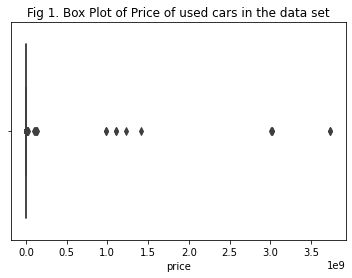

In [280]:
#box plot of target variable to visualise the outliers
sns.boxplot(data=df1,x='price').set(title="Fig 1. Box Plot of Price of used cars in the data set")
plt.savefig("fig 1.png")

In [281]:
# Maximum value of price in the dataframe df1
df1['price'].max()

3736928711

In [282]:
# Removing outliers from both the ends of the data and creation of subset dataframes
df3_nan = df1[df1['price']>1000]
df4_nan = df3_nan[df3_nan['price']<(0.0001*(df3_nan['price'].max()))]
df4_nan.shape   #Row and columns information of dataframe subset df4_nan

(379284, 14)

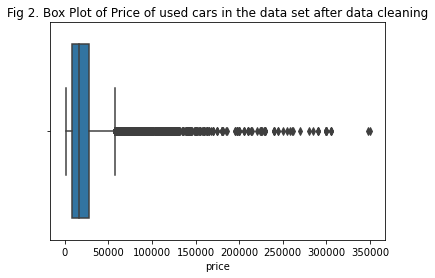

In [283]:
#Box plot after the initial (first iteration) of outlier removel of dataframe df4_nan
sns.boxplot(data=df4_nan,x='price').set(title="Fig 2. Box Plot of Price of used cars in the data set after data cleaning")
plt.savefig("fig 2.png")

In [284]:
# Maximum value of price in the dataframe df4_nan
df4_nan['price'].max()

349999

In [285]:
# Removing outliers from maximum end of the data and creation of subset dataframes DF_nan

DF_nan = df4_nan[df4_nan['price']<(0.6*(df4_nan['price'].max()))]

In [286]:
# Row and columns information of dataframe subset DF_nan
DF_nan.shape

(379239, 14)

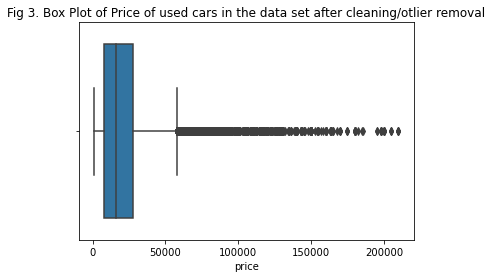

In [287]:
#Box plot after the removal (second iteration) of outlier of dataframe DF_nan
sns.boxplot(data=DF_nan,x='price').set(title="Fig 3. Box Plot of Price of used cars in the data set after cleaning/otlier removal")
plt.savefig("fig 3.png")

In [288]:
# Maximum value of price in the dataframe df4_nan
df4_nan['price'].max()

349999

In [289]:
# Removing outliers from the maximum end of the data and creation of subset dataframes

0.5*(df4_nan['price'].max())

174999.5

In [290]:
# Information of outliers in the maximum end of the data 

DF_nan[DF_nan['price']>(0.5*(df4_nan['price'].max()))]

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
23313,bakersfield,179988,2021.0,mercedes-benz,excellent,NaN,gas,NaN,clean,automatic,4wd,SUV,NaN,ca
36394,merced,179988,2021.0,mercedes-benz,excellent,NaN,gas,NaN,clean,automatic,4wd,SUV,NaN,ca
43630,orange county,179888,2018.0,aston-martin,like new,12 cylinders,gas,7800.0,clean,automatic,NaN,NaN,white,ca
69885,visalia-tulare,179988,2021.0,mercedes-benz,excellent,NaN,gas,NaN,clean,automatic,4wd,SUV,NaN,ca
92186,daytona beach,197999,2015.0,NaN,excellent,10 cylinders,gas,33875.0,clean,other,NaN,coupe,green,fl
92796,daytona beach,209999,2015.0,NaN,excellent,10 cylinders,gas,11828.0,clean,other,NaN,coupe,green,fl
93202,daytona beach,199999,2017.0,mercedes-benz,excellent,8 cylinders,gas,15189.0,clean,other,NaN,wagon,yellow,fl
99737,jacksonville,209999,2015.0,NaN,excellent,10 cylinders,gas,11828.0,clean,other,NaN,coupe,green,fl
101289,lakeland,209999,2015.0,NaN,excellent,10 cylinders,gas,11828.0,clean,other,NaN,coupe,green,fl
101811,lakeland,204999,2015.0,ferrari,excellent,12 cylinders,gas,30920.0,clean,other,NaN,coupe,red,fl


In [291]:
# Removing outliers from maximum end of the data and creation of subset dataframes DF_nan wihtout re-naming

DF_nan=DF_nan[DF_nan['price']<(0.5*(df4_nan['price'].max()))]
DF_nan.shape

(379203, 14)

#### 3.25 Handling outliers in other numerical columns like the odometer

<AxesSubplot:xlabel='odometer'>

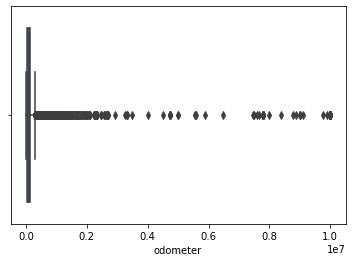

In [292]:
# plotting the box plot to have an idea of the distribution of the odometer numbers.
sns.boxplot(data=DF_nan,x='odometer')

<AxesSubplot:xlabel='year', ylabel='odometer'>

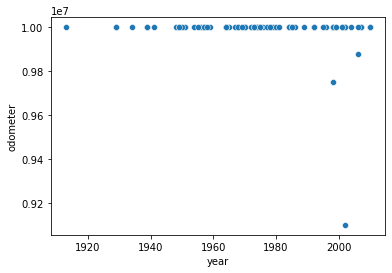

In [293]:
# plotting a scatter plot of the odometer numbers for all odometer measurements which are greater than 90%
# of the maximum odometer value 
sns.scatterplot(data=DF_nan[DF_nan['odometer']>(0.9*(DF_nan['odometer'].max()))],x='year',y='odometer')

<AxesSubplot:xlabel='year', ylabel='odometer'>

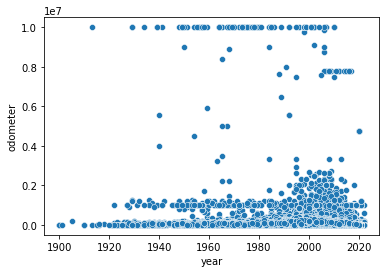

In [294]:
# scatter plot of the odometer measurement against the year.
sns.scatterplot(data=DF_nan,x='year',y='odometer')

#### 3.3 Dataframe 1 (DF_nan) nan value imputations and dropping

In [295]:
# Drop NAN value rows in df1 in place present in 'year' and 'odometer' columns

"""NOTE: id, size(72% NAN), vin, model(obscure data) present in original dataframe 
are not present in the new dataframe"""

DF_nan = DF_nan[DF_nan['year'].notna()]
DF_nan = DF_nan[DF_nan['odometer'].notna()]
print(DF_nan.shape)
print('The number of rows in our data after dropping nan rows in year and odometer are: ',DF_nan.shape[0])

(376023, 14)
The number of rows in our data after dropping nan rows in year and odometer are:  376023


In [296]:
# Impute NAN values present in the new df1 in columns less than 5% NAN values

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")
for key in sorted_nulldict:
    if key in ['year','odometer','id','model']:
        continue
    if sorted_nulldict[key] > 0 and sorted_nulldict[key]<5:
        if key in catg_column_lst:             
            DF_nan[key] = DF_nan[key].fillna(DF_nan[key].mode().iloc[0])
        else:
            DF_nan[key] = imputer.fit_transform(DF_nan[key])       

#### 3.4 Dataframe 1 (DF_nan) Label encoding for nan values and unique values

In [297]:
# Label NAN values as custom in the new df1 in columns with more than 5% nan values.

for key in sorted_nulldict:
    if key in ['VIN','size']:
        continue    
    if sorted_nulldict[key]>5 and key in catg_column_lst:
        DF_nan[key] = DF_nan[key].fillna('custom')

In [298]:
# DF_nan after null drop, impputation and NAN value label encoding
DF_nan.head().append(DF_nan.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/1230976407.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_nan.head().append(DF_nan.tail())


,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,auburn,33590,2014.0,gmc,good,8 cylinders,gas,57923.0,clean,other,custom,pickup,white,al
28,auburn,22590,2010.0,chevrolet,good,8 cylinders,gas,71229.0,clean,other,custom,pickup,blue,al
29,auburn,39590,2020.0,chevrolet,good,8 cylinders,gas,19160.0,clean,other,custom,pickup,red,al
30,auburn,30990,2017.0,toyota,good,8 cylinders,gas,41124.0,clean,other,custom,pickup,red,al
31,auburn,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
426875,wyoming,23590,2019.0,nissan,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,custom,wy
426876,wyoming,30590,2020.0,volvo,good,custom,gas,12029.0,clean,other,fwd,sedan,red,wy
426877,wyoming,34990,2020.0,cadillac,good,custom,diesel,4174.0,clean,other,custom,hatchback,white,wy
426878,wyoming,28990,2018.0,lexus,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy
426879,wyoming,30590,2019.0,bmw,good,custom,gas,22716.0,clean,other,rwd,coupe,custom,wy


In [299]:
# Information of DF_nan after null value dropping, imputing and remaining NAN value label encoding as 'custom'
DF_nan.shape

(376023, 14)

In [300]:
# Label encoding for 'region' and 'state'using Label encoder.

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
DF_nan['region'] = le.fit_transform(DF_nan['region'])
DF_nan['state'] = le.fit_transform(DF_nan['state'])
DF_nan['manufacturer'] = le.fit_transform(DF_nan['manufacturer'])

In [301]:
# Manual label encoding based on the labels we created with custom value being 0 in categorical

# columns 'condition','cylinders','fuel','title_status', 'transmission','drive',' paint_color'

# 8 manually encoded categorical + 3 label encoded categorical columns 
# + 2 numerical columns (13 feautures and 'price')

DF_nan['condition'] = DF_nan['condition'].apply(lambda x: ['custom','new','like new','excellent', 'good', 'fair', 'salvage'].index(x))
DF_nan['cylinders'] = DF_nan['cylinders'].apply(lambda x: ['custom','3 cylinders','4 cylinders','5 cylinders','6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders','other'].index(x))
DF_nan['fuel'] = DF_nan['fuel'].apply(lambda x: ['custom','diesel','electric','gas', 'hybrid', 'other'].index(x))
DF_nan['title_status'] = DF_nan['title_status'].apply(lambda x: ['custom','clean','lien','rebuilt', 'parts only', 'salvage','missing'].index(x))
DF_nan['transmission'] = DF_nan['transmission'].apply(lambda x: ['custom','automatic','manual','other', 'parts only', 'salvage','missing'].index(x))
DF_nan['drive'] = DF_nan['drive'].apply(lambda x: ['custom','fwd','4wd','rwd'].index(x))
DF_nan['type'] = DF_nan['type'].apply(lambda x: ['custom','coupe','hatchback','sedan','convertible','SUV','mini-van','van','wagon','pickup','truck','bus','offroad','other'].index(x))
DF_nan['paint_color'] = DF_nan['paint_color'].apply(lambda x: ['','black','blue','brown','custom','green','grey','orange','purple','red','silver','white','yellow'].index(x))

In [302]:
# Dataframe DF_nan after sklearn and manual label encoding
DF_nan.head().append(DF_nan.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/2021937850.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_nan.head().append(DF_nan.tail())


,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
27,16,33590,2014.0,14,4,5,3,57923.0,1,3,0,9,11,1
28,16,22590,2010.0,7,4,5,3,71229.0,1,3,0,9,2,1
29,16,39590,2020.0,7,4,5,3,19160.0,1,3,0,9,9,1
30,16,30990,2017.0,39,4,5,3,41124.0,1,3,0,9,9,1
31,16,15000,2013.0,13,3,4,3,128000.0,1,1,3,10,1,1
426875,397,23590,2019.0,31,4,4,3,32226.0,1,3,1,3,4,50
426876,397,30590,2020.0,41,4,0,3,12029.0,1,3,1,3,9,50
426877,397,34990,2020.0,6,4,0,1,4174.0,1,3,0,2,11,50
426878,397,28990,2018.0,23,4,4,3,30112.0,1,3,1,3,10,50
426879,397,30590,2019.0,4,4,0,3,22716.0,1,3,3,1,4,50


In [303]:
# Information (shape) of DF_nan after sklearn and manual label encoding
DF_nan.shape

(376023, 14)

#### 3.5 Dataframe 2 (DF) : All nan value dropping of df1

In [304]:
# dropping all null values in the dataframe df1 and creation of sub-set dataframe df2
df2 = df1.dropna()

In [305]:
# Information on subset dataframe DF after removal of all null values from df1
df2.shape

(117169, 14)

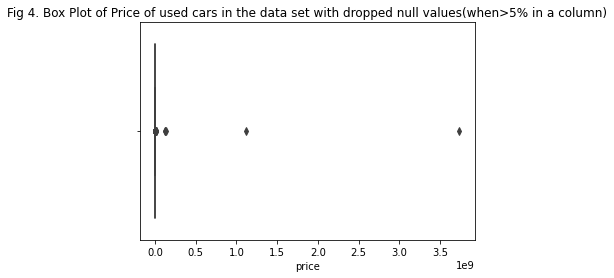

In [306]:
# Boxplot of target variable (price) in df2 created after dropping all null values in df1
sns.boxplot(data=df2,x='price').set(title="Fig 4. Box Plot of Price of used cars in the data set with dropped null values(when>5% in a column)")
plt.savefig("fig 4.png")

In [307]:
#Handling minimum outliers in the target variable of df2 and subset dataframe df5
df5 = df2[df2['price']>1000]

In [308]:
# information (shape) on number of observation of df5 after the removal of outliers from minimum end of dataframe df2
df5.shape

(110068, 14)

In [309]:
# Maximum price of the observation in the dataframe df3 after minimum outlier removal
df5['price'].max()

3736928711

In [310]:
# Examination of outliers in the maximum end of the dataframe df3 without renaming 
df5[df5['price']>(0.0005*(df5['price'].max()))]

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
29386,humboldt county,1111111111,1999.0,ford,good,8 cylinders,diesel,149000.0,clean,automatic,rwd,pickup,white,ca
68935,ventura county,2000000,2002.0,saturn,good,4 cylinders,gas,164290.0,clean,automatic,fwd,sedan,green,ca
136516,spokane / coeur d'alene,17000000,2007.0,ram,good,8 cylinders,diesel,170000.0,rebuilt,automatic,4wd,pickup,black,id
137807,spokane / coeur d'alene,123456789,1999.0,buick,like new,6 cylinders,gas,96000.0,clean,automatic,fwd,sedan,white,id
230753,asheville,135008900,2008.0,nissan,like new,8 cylinders,gas,110500.0,clean,automatic,4wd,truck,grey,nc
286323,akron / canton,12345678,2019.0,chevrolet,good,8 cylinders,gas,100000.0,clean,automatic,4wd,truck,black,oh
286324,akron / canton,12345678,2019.0,chevrolet,good,8 cylinders,gas,100000.0,clean,automatic,4wd,truck,black,oh
288400,akron / canton,12345678,2019.0,chevrolet,good,8 cylinders,gas,100000.0,clean,automatic,4wd,truck,black,oh
288401,akron / canton,12345678,2019.0,chevrolet,good,8 cylinders,gas,100000.0,clean,automatic,4wd,truck,black,oh
303014,youngstown,12345678,2019.0,chevrolet,good,8 cylinders,gas,100000.0,clean,automatic,4wd,truck,black,oh


In [311]:
# Removal of outliers from the maximum end of the dataframe df5 and subsetting it to dataframe df6

df6 = df5[df5['price']<(0.0001*(df5['price'].max()))]
df6.shape  #information on number observations of dataframe df5 created after the removal of max end outliers from df5

(110053, 14)

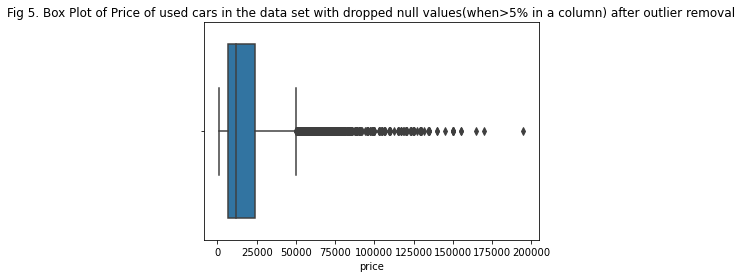

In [312]:
#Box plot of df6 after removal (first iteration) of low and high end doutliers
sns.boxplot(data=df6,x='price').set(title="Fig 5. Box Plot of Price of used cars in the data set with dropped null values(when>5% in a column) after outlier removal")
plt.savefig("fig 5.png")

In [313]:
# Maximum price in the dataframe df4
df6['price'].max()

195000

In [314]:
# examining outliers in the masimum ned of df4
df6[df6['price']>(0.6*(df6['price'].max()))]

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
1727,birmingham,130000,2019.0,chevrolet,like new,8 cylinders,gas,5000.0,clean,automatic,rwd,coupe,blue,al
2922,huntsville / decatur,140000,2015.0,jeep,like new,6 cylinders,gas,49658.0,rebuilt,other,fwd,SUV,yellow,al
10518,phoenix,123456,1989.0,chevrolet,like new,8 cylinders,gas,73450.0,clean,automatic,rwd,convertible,red,az
12156,phoenix,135000,1967.0,chevrolet,excellent,8 cylinders,gas,3000.0,clean,manual,rwd,coupe,silver,az
13024,prescott,119995,2021.0,chevrolet,new,8 cylinders,gas,167.0,clean,automatic,rwd,convertible,orange,az
30632,inland empire,125000,1963.0,chevrolet,like new,8 cylinders,gas,700.0,clean,manual,rwd,convertible,yellow,ca
34670,los angeles,120000,2018.0,mercedes-benz,good,6 cylinders,diesel,64000.0,clean,automatic,4wd,van,white,ca
36337,merced,120000,2012.0,chevrolet,good,8 cylinders,gas,265000.0,clean,automatic,4wd,truck,white,ca
37260,modesto,125000,1968.0,chevrolet,excellent,8 cylinders,gas,10481.0,clean,manual,4wd,coupe,blue,ca
40249,monterey bay,135000,2017.0,mercedes-benz,like new,8 cylinders,gas,1758.0,clean,automatic,4wd,convertible,custom,ca


In [315]:
# Removal (second iteration) of outliers from the maximum of dataframe df4 and subsetting it to DF
DF = df6[df6['price']<(0.6*(df6['price'].max()))]

In [316]:
# Information on the shape of dataframe DF created after the removal of minimum outliers and two iterations of maximum ned outliers
DF.shape

(109998, 14)

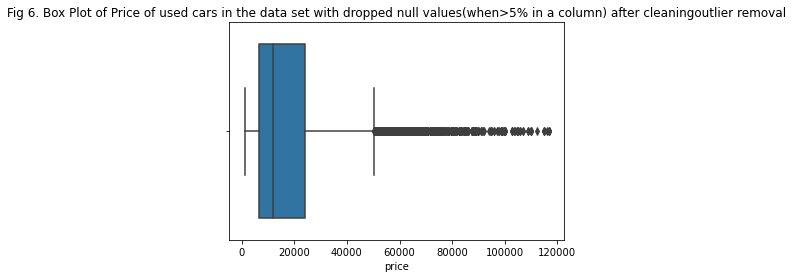

In [317]:
# Boxplot of DF created after removal of nullvalues, minimum and maximum (2 itarations) end of data outliers.
sns.boxplot(data=DF,x='price').set(title="Fig 6. Box Plot of Price of used cars in the data set with dropped null values(when>5% in a column) after cleaningoutlier removal")
plt.savefig("fig 6.png")

In [318]:
#Minimum price present in Dtatframe DF
DF['price'].min()

1012

In [319]:
#scanning DF created after dropping all null and removal of outliers
DF.head().append(DF.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/2392892888.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF.head().append(DF.tail())


,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
31,auburn,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
32,auburn,27990,2012.0,gmc,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al
33,auburn,34590,2016.0,chevrolet,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al
34,auburn,35000,2019.0,toyota,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al
35,auburn,29990,2016.0,chevrolet,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al
426859,wyoming,48590,2020.0,cadillac,good,6 cylinders,gas,7701.0,clean,other,fwd,other,black,wy
426860,wyoming,39990,2017.0,infiniti,good,8 cylinders,gas,41664.0,clean,automatic,4wd,other,black,wy
426866,wyoming,32990,2016.0,infiniti,good,8 cylinders,gas,55612.0,clean,automatic,rwd,other,black,wy
426874,wyoming,33590,2018.0,lexus,good,6 cylinders,gas,30814.0,clean,automatic,rwd,sedan,white,wy
426878,wyoming,28990,2018.0,lexus,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy


#### 3.6. Encoding labels for the unique values present in the cateogorical columns of DF

In [320]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i_col in ['region','state','manufacturer','condition','cylinders','fuel','title_status','transmission','drive','type','paint_color']:
    DF[i_col] = le.fit_transform(DF[i_col])

DF = DF.reset_index(drop=True)

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/2841812004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF[i_col] = le.fit_transform(DF[i_col])


#### 3.7. Construction of final dataframe(s)

#### DATAFRAME 1 (DF_nan) which contains labelled NAN values after outlier removal.

In [321]:
# Resetting the index for continous dataframe index of DF_nan
DF_nan = DF_nan.reset_index(drop=True) 
"""setting drop=true ensures the previous index is dropped."""
DF_nan

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,16,33590,2014.0,14,4,5,3,57923.0,1,3,0,9,11,1
1,16,22590,2010.0,7,4,5,3,71229.0,1,3,0,9,2,1
2,16,39590,2020.0,7,4,5,3,19160.0,1,3,0,9,9,1
3,16,30990,2017.0,39,4,5,3,41124.0,1,3,0,9,9,1
4,16,15000,2013.0,13,3,4,3,128000.0,1,1,3,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376018,397,23590,2019.0,31,4,4,3,32226.0,1,3,1,3,4,50
376019,397,30590,2020.0,41,4,0,3,12029.0,1,3,1,3,9,50
376020,397,34990,2020.0,6,4,0,1,4174.0,1,3,0,2,11,50
376021,397,28990,2018.0,23,4,4,3,30112.0,1,3,1,3,10,50


#### DATAFRAME 2 (DF) which contains labelled NAN values after outlier removal.

In [322]:
# Resetting the index for continous dataframe index of DF

DF = DF.reset_index(drop=True) 
"""setting drop=true ensures the previous index is dropped."""
DF

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,16,15000,2013.0,13,0,5,2,128000.0,0,0,2,10,0,1
1,16,27990,2012.0,14,2,6,2,68696.0,0,2,0,8,0,1
2,16,34590,2016.0,7,2,5,2,29499.0,0,2,0,8,9,1
3,16,35000,2019.0,39,0,5,2,43000.0,0,0,0,10,5,1
4,16,29990,2016.0,7,2,5,2,17302.0,0,2,0,8,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109993,396,48590,2020.0,6,2,5,2,7701.0,0,2,1,7,0,50
109994,396,39990,2017.0,18,2,6,2,41664.0,0,0,0,7,0,50
109995,396,32990,2016.0,18,2,6,2,55612.0,0,0,2,7,0,50
109996,396,33590,2018.0,23,2,5,2,30814.0,0,0,2,9,10,50


#### 3.8. Estimation Pearson's correlation co-effcient 

#### DATAFRAME 1 (DF_nan) which contains labelled NAN values after outlier removal.

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/2483173481.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(DF_nan.corr(method='pearson'), dtype=np.bool))


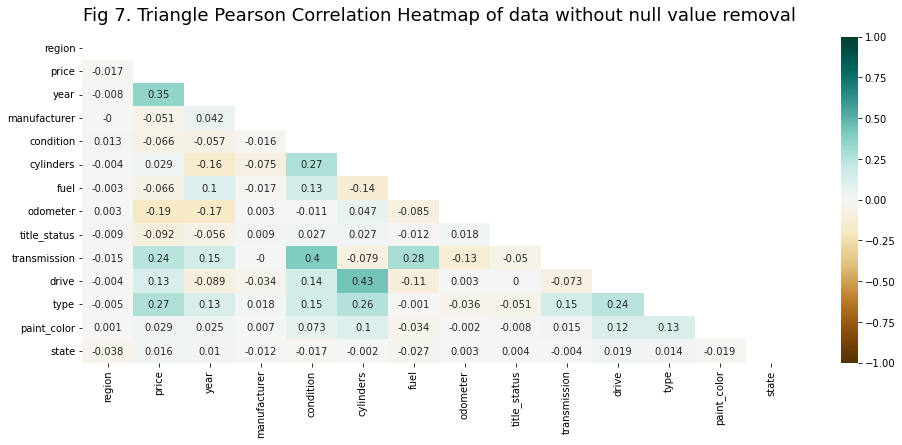

In [323]:
# Pearson Correlation Coefficient heatmap with umerical values 

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(DF_nan.corr(method='pearson'), dtype=np.bool))
heatmap = sns.heatmap(round(DF_nan.corr(),3), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Fig 7. Triangle Pearson Correlation Heatmap of data without null value removal', fontdict={'fontsize':18}, pad=16);
plt.savefig('fig 7.png')

We have conducted a correlation analysis of the data with encoded/imputed null values by plotting the Pearson's correlation coefficient in the traingle heatmap.In Fig.7, we see that there is not a clear linear correlation(coefficient>0.6) between any vaiables. It also shows that price is positively affected year,transmission, drive and type of the vehicle and negatively correlated with odometer readings. This indicates that the system might be better expressed by a higher degree polynomial linear regression than Ordinary least squares linear regression. This forms the basis on which we will build our models. ALthough we will just check OLS, we would do more analysis with higher degree polynomial regression. 

#### DATAFRAME 2 (DF) which contains labelled NAN values after outlier removal

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/4180550107.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(DF.corr(method='pearson'), dtype=np.bool))


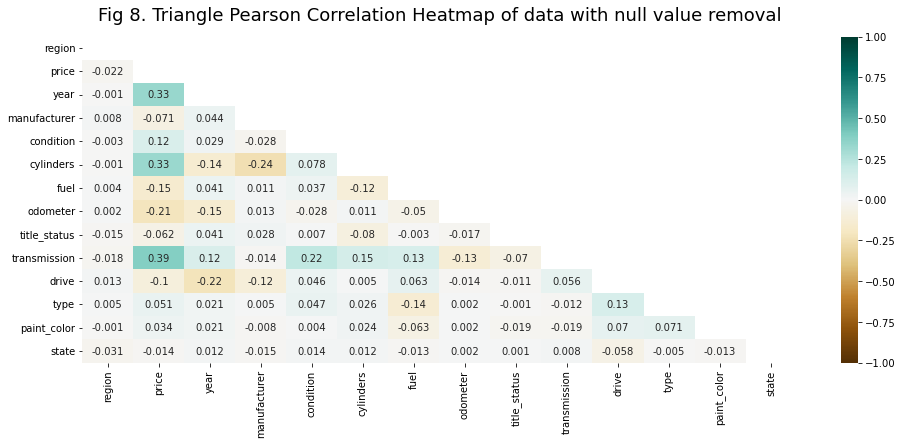

In [324]:
# Pearson Correlation Coefficient heatmap with umerical values 

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(DF.corr(method='pearson'), dtype=np.bool))
heatmap = sns.heatmap(round(DF.corr(),3), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Fig 8. Triangle Pearson Correlation Heatmap of data with null value removal', fontdict={'fontsize':18}, pad=16);
plt.savefig('fig 8.png')

We have conducted a correlation analysis of the data after dropping all null values by plotting the Pearson's correlation coefficient in the traingle heatmap.In Fig.8, we see that there is not a clear linear correlation(coefficient>0.6) between any vaiables. It also shows that price is positively affected year,transmission,cylinders,condition and type of the vehicle and negatively correlated with odometer readings and fuel. This indicates that the system might be better expressed by a higher degree polynomial linear regression than Ordinary least squares linear regression. This forms the basis on which we will build our models. Although we will just check OLS, we would do more analysis with higher degree polynomial regression. 

### 4. Modeling and Evaluation

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### DATAFRAME 1 (DF_nan) which contains labelled NAN values after outlier removal. 

#### 4.1. Creating Training and Development data for modeling and model improvememnt

In [132]:
# split the data into training data and develoment data using 

X = DF_nan.drop(columns = ['price'])
y = DF_nan['price']
        
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [133]:
X_train.head().append(X_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_621/4211938313.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.head().append(X_train.tail())


,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
257872,59,2018.0,25,3,2,3,7800.0,1,2,3,4,11,35
318209,230,2014.0,7,0,0,3,59091.0,3,1,0,0,4,42
359807,312,2018.0,31,4,5,3,24792.0,1,1,0,9,11,47
120554,340,2019.0,14,0,0,1,28154.0,1,1,2,10,11,13
212782,282,2011.0,13,3,2,3,135000.0,3,1,1,3,5,27
259178,61,2012.0,13,0,0,3,123161.0,1,1,1,7,11,35
365838,11,2016.0,4,2,2,3,16000.0,1,1,2,0,4,48
131932,116,2016.0,31,4,4,3,24661.0,1,1,2,9,11,15
146867,166,2008.0,21,0,0,3,114419.0,1,1,0,0,4,16
121958,32,2017.0,34,4,5,3,22401.0,1,3,2,9,2,14


In [134]:
X_train.shape

(251935, 13)

In [135]:
y_train.head().append(y_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_621/3570967498.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train.head().append(y_train.tail())


257872    27500
318209     7900
359807    41999
120554    64999
212782     4500
259178    12481
365838    24500
131932    29990
146867     7995
121958    35590
Name: price, dtype: int64

In [136]:
# create the baseline for error analysis
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_dev = np.ones(shape = y_dev.shape)*y_dev.mean()

mae_baseline_train = mean_absolute_error(baseline_train, y_train)
mae_baseline_dev = mean_absolute_error(baseline_dev, y_dev)

mape_baseline_train = mean_absolute_percentage_error(baseline_train, y_train)
mape_baseline_dev = mean_absolute_percentage_error(baseline_dev, y_dev)

msle_baseline_train = mean_squared_log_error(baseline_train, y_train)
msle_baseline_dev = mean_squared_log_error(baseline_dev, y_dev)

In [137]:
#printing the baseline error
print('The mean absolute baseline training error is: ', mae_baseline_train)
print('The mean absolute baseline testing error is: ', mae_baseline_dev)

print('The mean absolute percentage baseline training error is: ', mape_baseline_train)
print('The mean absolute percentage baseline testing error is: ', mape_baseline_dev)

print('The mean squared log baseline training error is: ', msle_baseline_train)
print('The mean squared log baseline testing error is: ', msle_baseline_dev)

The mean absolute baseline training error is:  11517.167750130237
The mean absolute baseline testing error is:  11487.880180150905
The mean absolute percentage baseline training error is:  0.59028837081028
The mean absolute percentage baseline testing error is:  0.5893634514478453
The mean squared log baseline training error is:  0.795244359762045
The mean squared log baseline testing error is:  0.7946662579670623


During the first iteration of CRISP-DM framework of model building, we have evaluated the baseline error (which can be coarsely interpreted as a baseline  model where all the points regress towards the mean like in a Linear regression model) for the Dataframe that has encoded/imputed null values and outliers in price removed. We have chosen Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE) and Mean Squared Log Error (MSLE) as the metrics for evaluating our models. 

We chose MAE beacuse it computes to more easily interprectable errors and gives less weight to outliers. However a model with good 𝑀𝐴𝐸 can have punctually very high errors. Hence, we take MAPE and MSLE also into consideartion because, MAPE represents the additive error not with just with respect to the mean but also the data point itself. This reduces the error that may enter the model. Also, we choose MLSE instead of MSE (Mean Squared Error) or RMSE (Root Mean Squared Error) beacause squared erros give more weightage to outliers and used car dataset represents a complex system where we can expect to have classes of data (eg: antique cars) that may be expressing themselves as outliers in regression models. It is to be noted that in all these errors the lower the value of the error term the better the model. 

We also would compute R^2 values of the models that represents the fitness of the model to represent all the datat points sufficiently such that predictions can be made for unknown values as close to the true value as possible. It varies between 0 and 1 with values above .70 representing a good fit. 

#### 4.2 Model building

We chose to test :
1. OLS ElasticNet regression:  It combines the ease of Lasso regression to handle many features and the better numerical stability of ridge regression that aids in better convergance. Further we also have zeors values of price and any regression model that underpredicts the target variable would yield negative price vales. We can fix this potential issue either by using a regression model that can enforce positive predictions like ElasticNet or use target variable tranformation by converting to logarithmic scale. We chose to do the LOG tranformation to the final model(s) that gives us the minimum errors and best fit. 

2. Polynomial Features ElasticNet regression: Pearson correlation plot indicates a very weak linear corrrelation between feautures or between features and price. Hence after modelling the data with OLS we try to compute the performance of polynomial degree functions with ElasticNet regression. 
We choose to restric our polynomial degrees from 2-4 as with the given number of features in the data, the totla number of features would increase rapidly and the process would become computationally inefficient. We also chose to manually change the degrees to find the best polynomial degree as grid search is very time-intensive on a laptop. 

2a. Grid Search: We would use Grid search CV to tune the model with hyperparameters to further lower the error values and increase the fit of the model.
2b. In order to find the feautures of the data set that are most expressed in the price we do a permutation importance on the model that has been built. The output is usully a weighted feautures that represent the weight with which they affect the price of the used vehicle. 

2c. Polynomial Features BayesianARD regression: We chose BayesianARD regression because of the flexibility of the bayesian models to adapt to the data in hand. Further Bayesian regressions are based on bayesian probablity where causal/conditional effects are prominant. The Automatic Relevance Determination (as being implemented in ARDRegression) is a kind of linear model where the guassian distribution is treated to be more elliptical than sperical. 

2d. Polynomial features BayesianRidge regression:The BayesianRidge estimates a probabilistic model of the regression through regularization used in Ridge regression and classification is equivalent to finding a maximum a posterior estimation under a spherical Gaussian. Such model might be especially useful for dataset like this with multiple features whose values could be expressed a probablity based on another previous feature. 
    

#### MODEL 1: Elastic Net regression, Recurssive feature elimination, gradient decent optimization

In [138]:
# scaling columns as aplha is sensitive to magnitude of feature

"""We use standard scalar to z = (x - u) / s, where u is the mean of the training samples or 
zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False."""

"""Standardization of a dataset is a common requirement for many machine learning estimators: 
they might behave badly if the individual features do not more or less look like standard normally distributed data 
(e.g. Gaussian with 0 mean and unit variance)."""

"""For instance many elements used in the objective function of a learning algorithm 
(such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) 
assume that all features are centered around 0 and have variance in the same order. """

"""If a feature has a variance that is orders of magnitude larger than others, 
it might dominate the objective function and make the estimator unable to learn 
from other features correctly as expected."""

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                        )
# Building pipe line for the selected model

pipeline1 = Pipeline([('prep', preprocessor),
                      ('selector',RFE(LinearRegression(),n_features_to_select=6)),
                      ('lossfunction', ElasticNet(alpha=100, positive= True, random_state = 42, fit_intercept=False))])
pipeline1.fit(X_train,y_train)
                      

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('selector',
                 RFE(estimator=LinearRegression(), n_features_to_select=6)),
                ('lossfunction',
                 ElasticNet(alpha=100, fit_intercept=False, positive=True,
                            random_state=42))])

In [139]:
train_preds = pipeline1.predict(X_train)
dev_preds = pipeline1.predict(X_dev)
pipeline1_train_mae = mean_absolute_error(y_train, train_preds)
pipeline1_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline1_train_mae)
print('The mean absolute testing error is: ', pipeline1_dev_mae)

The mean absolute training error is:  14852.224997228961
The mean absolute testing error is:  14839.018766331928


In [140]:
pipeline1_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline1_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline1_train_mape)
print('MAPE Dev is: ', pipeline1_dev_mape)

MAPE Train is:  0.670960887062342
MAPE Dev is:  0.6712606384640029


In [141]:
pipeline1_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline1_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline1_train_msle)
print('MSLE Dev is: ', pipeline1_dev_msle)

MSLE Train is:  1.9533240689013416
MSLE Dev is:  1.9549824324093799


In [142]:
min(train_preds)

1569.9189498469912

In [143]:
min(dev_preds)

1569.9189498469912

#### MODEL 2: Polynomial regression, elasticnet regression, gradient decent optimization

In [144]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline2 = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ElasticNet(alpha=100, positive= True, random_state = 42, fit_intercept=False))
                     ])
                    
pipeline2.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 ElasticNet(alpha=100, fit_intercept=False, positive=True,
                            random_state=42))])

In [145]:
train_preds = pipeline2.predict(X_train)
dev_preds = pipeline2.predict(X_dev)
pipeline2_train_mae = mean_absolute_error(y_train, train_preds)
pipeline2_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline2_train_mae)
print('The mean absolute testing error is: ', pipeline2_dev_mae)

The mean absolute training error is:  9990.19602035515
The mean absolute testing error is:  9969.146724186157


In [146]:
pipeline2_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline2_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline2_train_mape)
print('MAPE Dev is: ', pipeline2_dev_mape)

MAPE Train is:  1.0722265756742824
MAPE Dev is:  1.0725840379516474


In [147]:
pipeline2_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline2_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline2_train_msle)
print('MSLE Dev is: ', pipeline2_dev_msle)

MSLE Train is:  0.6608548401350263
MSLE Dev is:  0.66123878704568


In [148]:
min(train_preds)

11952.689903432807

In [149]:
min(dev_preds)

11913.259561404511

#### MODEL 2a: Polynomial regression, elasticnet regression, gradient decent optimization, Grid search for hyperparameter optimization

In [150]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )
param_dict = {'lossfunction__alpha':[.001,0.1, 1.0, 10.0, 100.0, 1000.0]}

# Building pipe line for the selected model 

pipeline2a = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ElasticNet(positive= True, random_state = 42, fit_intercept=False))
                     ])

grid_2a = GridSearchCV(pipeline2a, param_grid=param_dict) 

grid_2a.fit(X_train,y_train)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e+13, tolerance: 1.210e+10
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e+13, tolerance: 1.206e+10
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['odometer'])])),
                                       ('feature_transform',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('lossfunction',
                                        ElasticNet(fit_intercept=False,
                                                   positive=True,
                                                   random_state=42))]),
             param_grid={'lossfunction__alpha': [0.001, 0.1, 1.0, 10.0, 100.0,
                                                

In [156]:
train_preds = grid_2a.predict(X_train)
dev_preds = grid_2a.predict(X_dev)
grid_2a_train_mae = mean_absolute_error(y_train, train_preds)
grid_2a_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', grid_2a_train_mae)
print('The mean absolute testing error is: ', grid_2a_dev_mae)

The mean absolute training error is:  9968.847239722792
The mean absolute testing error is:  9947.208289276723


In [157]:
grid_2a_train_mape = mean_absolute_percentage_error(y_train, train_preds)
grid_2a_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', grid_2a_train_mape)
print('MAPE Dev is: ', grid_2a_dev_mape)

MAPE Train is:  1.0677033838819827
MAPE Dev is:  1.067944528485889


In [158]:
grid_2a_train_msle = mean_squared_log_error(train_preds, y_train)
grid_2a_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', grid_2a_train_msle)
print('MSLE Dev is: ', grid_2a_dev_msle)

MSLE Train is:  0.6581918848628645
MSLE Dev is:  0.6585132738403919


In [159]:
min(train_preds)

11916.051163272197

In [160]:
min(dev_preds)

11875.546083946072

####  MODEL 2b: Polynomial regression, elasticnet regression, gradient decent optimization, Grid search for hyperparameter optimization, Permutation importance for feature selection

In [161]:
# Create a pipeline model with the best alpha to select features

best_alpha = grid_2a.best_params_

pipeline2b_best = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ElasticNet(alpha= best_alpha['lossfunction__alpha'], positive= True, random_state = 42, fit_intercept=False))
                     ])

pipeline2b_best.fit(X_train,y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 ElasticNet(alpha=0.1, fit_intercept=False, positive=True,
                            random_state=42))])

In [162]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline2b_best, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

type    0.100 +/- 0.001
transmission0.091 +/- 0.001
drive   0.025 +/- 0.001
year    0.009 +/- 0.000
cylinders0.003 +/- 0.000
state   0.002 +/- 0.000
fuel    0.000 +/- 0.000


In [163]:
pipeline2b_best.score(X_dev,y_dev)

0.14834023598077528

Note that the importance values for the top features represent a large fraction of the reference score of 0.149.

In [164]:
train_preds = pipeline2b_best.predict(X_train)
dev_preds = pipeline2b_best.predict(X_dev)
pipeline2b_best_train_mae = mean_absolute_error(y_train, train_preds)
pipeline2b_best_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline2b_best_train_mae)
print('The mean absolute testing error is: ', pipeline2b_best_dev_mae)

The mean absolute training error is:  9968.847239722792
The mean absolute testing error is:  9947.208289276723


In [165]:
pipeline2b_best_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline2b_best_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline2b_best_train_mape)
print('MAPE Dev is: ', pipeline2b_best_dev_mape)

MAPE Train is:  1.0677033838819827
MAPE Dev is:  1.067944528485889


In [166]:
pipeline2b_best_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline2b_best_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline2b_best_train_msle)
print('MSLE Dev is: ', pipeline2b_best_dev_msle)

MSLE Train is:  0.6581918848628645
MSLE Dev is:  0.6585132738403919


In [167]:
min(train_preds)

11916.051163272197

In [168]:
min(dev_preds)

11875.546083946072

####  MODEL 2c: Polynomial regression, Bayesian ARDRegression, gradient decent optimization.

In [169]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline2c = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ARDRegression(fit_intercept=False))
                     ])
                    
pipeline2c.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction', ARDRegression(fit_intercept=False))])

In [170]:
train_preds = pipeline2c.predict(X_train)
dev_preds = pipeline2c.predict(X_dev)
pipeline2c_train_mae = mean_absolute_error(y_train, train_preds)
pipeline2c_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline2c_train_mae)
print('The mean absolute dev error is: ', pipeline2c_dev_mae)

The mean absolute training error is:  8184.982769501971
The mean absolute dev error is:  8168.774079281784


In [171]:
pipeline2c_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline2c_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline2c_train_mape)
print('MAPE Dev is: ', pipeline2c_dev_mape)

MAPE Train is:  0.7147958959544584
MAPE Dev is:  0.7131655124706822


In [172]:
train_preds_noneg = train_preds[train_preds>0]
y_train_noneg = y_train[train_preds>0]
dev_preds_noneg = dev_preds[dev_preds>0]
y_dev_noneg = y_dev[dev_preds>0]
pipeline2c_train_msle = mean_squared_log_error(train_preds_noneg, y_train_noneg)
pipeline2c_dev_msle = mean_squared_log_error(dev_preds_noneg, y_dev_noneg)

print('MSLE Train is: ', pipeline2c_train_msle)
print('MSLE Dev is: ', pipeline2c_dev_msle)

MSLE Train is:  0.47357625158097993
MSLE Dev is:  0.47502625119817454


In [173]:
min(train_preds)

-262984.2009287203

In [174]:
min(dev_preds)

-224196.01447994332

In [175]:
train_preds

array([23368.38602664, 14740.99264625, 23759.27384057, ...,
       22280.20452918,  9862.34985283, 38478.61059932])

In [176]:
X_train.iloc[np.argmin(train_preds)]

region              246.0
year               1934.0
manufacturer         13.0
condition             3.0
cylinders             8.0
fuel                  5.0
odometer        9999999.0
title_status          4.0
transmission          3.0
drive                 3.0
type                  0.0
paint_color           2.0
state                 6.0
Name: 76309, dtype: float64

In [177]:
len(train_preds[train_preds<0])

1600

####  MODEL 2d: Polynomial regression, BayesianRidge, gradient decent optimization.

In [178]:
# scaling columns as alpha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )
    
pipeline2d = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', BayesianRidge(fit_intercept=False,lambda_1=10,lambda_2=10))
                     ])
                    
pipeline2d.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 BayesianRidge(fit_intercept=False, lambda_1=10, lambda_2=10))])

In [179]:
train_preds = pipeline2d.predict(X_train)
dev_preds = pipeline2d.predict(X_dev)
pipeline2d_train_mae = mean_absolute_error(y_train, train_preds)
pipeline2d_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline2d_train_mae)
print('The mean absolute development error is: ', pipeline2d_dev_mae)

The mean absolute training error is:  5533.994193942739
The mean absolute development error is:  5535.449880264221


In [180]:
pipeline2d_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline2d_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline2d_train_mape)
print('MAPE Dev is: ', pipeline2d_dev_mape)

MAPE Train is:  0.5006379235272598
MAPE Dev is:  0.5053488687738698


In [181]:
train_preds_noneg = train_preds[train_preds>0]
y_train_noneg = y_train[train_preds>0]
dev_preds_noneg = dev_preds[dev_preds>0]
y_dev_noneg = y_dev[dev_preds>0]
pipeline2d_train_msle = mean_squared_log_error(train_preds_noneg, y_train_noneg)
pipeline2d_dev_msle = mean_squared_log_error(dev_preds_noneg, y_dev_noneg)

print('MSLE Train is: ', pipeline2d_train_msle)
print('MSLE Dev is: ',pipeline2d_dev_msle)

MSLE Train is:  0.30406388972355064
MSLE Dev is:  0.30574259348059335


In [182]:
min(train_preds)

-101510.82877791673

In [183]:
min(dev_preds)

-430931.86014054716

In [184]:
train_preds

array([25307.48353904, 13743.68477657, 33126.61730692, ...,
       28338.45699017, 10356.71494614, 38167.42966158])

In [185]:
X_train.iloc[np.argmin(train_preds)]

region              197.0
year               2005.0
manufacturer         13.0
condition             3.0
cylinders             5.0
fuel                  3.0
odometer        2006000.0
title_status          1.0
transmission          1.0
drive                 3.0
type                  4.0
paint_color           4.0
state                 4.0
Name: 27968, dtype: float64

In [186]:
len(train_preds[train_preds<0])

5174

#### EVALUATION ####
For the data set that was created after imputing/encoding null values we found that BayesianRidge regression with polynomial features gave the least MAE (5535.4), MAPE (0.505) and MSLE (.306) which corresponds to ~50% , ~20%, ~60% decrease from the baseline errors. However, this model has predicted few extreme negative values. Upon further examination by looking at the feautres of the corresponding pbservation we find that the odometer readings do not quite represent the real-world data indicating possible erroneuos data entry. In the next iteration of the CRISP-DM frame work we attempt to further fine tune the model built by addressing data integrity issues in odometer column.  

#### DATAFRAME 2 (DF) in which all NAN values are removed.

#### 4.3. Creating Training and Development data for modeling and model improvememnt

In [187]:
# split the data into training data and develoment data using 

X = DF.drop(columns = ['price'])
y = DF['price']
        
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [188]:
X_train.head().append(X_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_621/4211938313.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.head().append(X_train.tail())


,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
49960,82,2009.0,20,2,3,2,207000.0,0,0,0,0,5,22
50095,82,2007.0,32,0,5,2,117928.0,0,0,1,9,4,22
94414,6,2014.0,20,0,3,2,122432.0,0,0,1,0,10,43
52978,294,2006.0,39,0,5,2,200200.0,0,0,1,5,0,22
103308,287,2008.0,7,0,6,2,119000.0,0,0,2,10,2,45
54886,216,2006.0,39,0,3,3,243000.0,0,0,1,4,9,23
76820,61,2014.0,8,0,5,2,192005.0,0,0,2,11,8,35
103694,288,2012.0,7,0,3,2,141030.0,0,0,1,0,0,45
860,151,2017.0,39,2,3,2,33591.0,0,0,1,9,0,1
15795,350,2015.0,7,0,6,2,97406.0,0,0,2,8,10,4


In [189]:
X_train.shape

(73698, 13)

In [190]:
y_train.head().append(y_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_621/3570967498.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train.head().append(y_train.tail())


49960      3900
50095      4495
94414      8600
52978      5599
103308     8000
54886      3200
76820      6995
103694     6490
860       12500
15795     37995
Name: price, dtype: int64

In [191]:
# create the baseline for error analysis
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_dev = np.ones(shape = y_dev.shape)*y_dev.mean()

mae_baseline_train = mean_absolute_error(baseline_train, y_train)
mae_baseline_dev = mean_absolute_error(baseline_dev, y_dev)

mape_baseline_train = mean_absolute_percentage_error(baseline_train, y_train)
mape_baseline_dev = mean_absolute_percentage_error(baseline_dev, y_dev)

msle_baseline_train = mean_squared_log_error(baseline_train, y_train)
msle_baseline_dev = mean_squared_log_error(baseline_dev, y_dev)

In [192]:
#printing the baseline error
print('The mean absolute baseline training error is: ', mae_baseline_train)
print('The mean absolute baseline development error is: ', mae_baseline_dev)

print('The mean absolute percentage baseline training error is: ', mape_baseline_train)
print('The mean absolute percentage baseline development error is: ', mape_baseline_dev)

print('The mean squared log baseline training error is: ', msle_baseline_train)
print('The mean squared log baseline development error is: ', msle_baseline_dev)

The mean absolute baseline training error is:  10369.35079943669
The mean absolute baseline development error is:  10320.600184868974
The mean absolute percentage baseline training error is:  0.634957965366732
The mean absolute percentage baseline development error is:  0.6357429453154049
The mean squared log baseline training error is:  0.8097640280144478
The mean squared log baseline development error is:  0.8149073675157695


#### 4.4 Model building

We chose to test the same combination of degrees, regression and methods for this dataset also except for few changes which have been mentioned below along with the explanations of the modeling method selction:

3. OLS ElasticNet regression:  It combines the ease of Lasso regression to handle many features and the better numerical stability of ridge regression that aids in better convergance. Further we also have zeors values of price and any regression model that underpredicts the target variable would yield negative price vales. We can fix this potential issue either by using a regression model that can enforce positive predictions like ElasticNet or use target variable tranformation by converting to logarithmic scale. We chose to do the LOG tranformation to the final model(s) that gives us the minimum errors and best fit. 

4. Polynomial Features ElasticNet regression: Pearson correlation plot indicates a very weak linear corrrelation between feautures or between features and price. Hence after modelling the data with OLS we try to compute the performance of polynomial degree functions with ElasticNet regression. 
We choose to restric our polynomial degrees from 2-4 as with the given number of features in the data, the totla number of features would increase rapidly and the process would become computationally inefficient. We also chose to manually change the degrees to find the best polynomial degree as grid search is very time-intensive on a laptop. We also manually find the best value of hyperparameter alpha as a grid search was found to be a time consuming step in the previuos dataset. We also combined permutaion importance in ths step to find the important features affecting the price of the used cars. 
 
4a. Polynomial Features BayesianARD regression: We chose BayesianARD regression because of the flexibility of the bayesian models to adapt to the data in hand. Further Bayesian regressions are based on bayesian probablity where causal/conditional effects are prominant. The Automatic Relevance Determination (as being implemented in ARDRegression) is a kind of linear model where the guassian distribution is treated to be more elliptical than sperical. 

4b. Polynomial features BayesianRidge regression:The BayesianRidge estimates a probabilistic model of the regression through regularization used in Ridge regression and classification is equivalent to finding a maximum a posterior estimation under a spherical Gaussian. Such model might be especially useful for dataset like this with multiple features whose values could be expressed a probablity based on another previous feature. 

#### MODEL 3: Elastic Net regression, Recurssive feature elimination, gradient decent optimization

In [193]:
# scaling columns as aplha is sensitive to magnitude of feature

"""We use standard scalar to z = (x - u) / s, where u is the mean of the training samples or 
zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False."""

"""Standardization of a dataset is a common requirement for many machine learning estimators: 
they might behave badly if the individual features do not more or less look like standard normally distributed data 
(e.g. Gaussian with 0 mean and unit variance)."""

"""For instance many elements used in the objective function of a learning algorithm 
(such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) 
assume that all features are centered around 0 and have variance in the same order. """

"""If a feature has a variance that is orders of magnitude larger than others, 
it might dominate the objective function and make the estimator unable to learn 
from other features correctly as expected."""

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                        )
# Building pipe line for the selected model

pipeline3 = Pipeline([('prep', preprocessor),
                      ('selector',RFE(LinearRegression(),n_features_to_select=7)),
                      ('lossfunction', ElasticNet(alpha=0.1, positive= True, random_state = 42, fit_intercept=False))])
pipeline3.fit(X_train,y_train)
                      

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('selector',
                 RFE(estimator=LinearRegression(), n_features_to_select=7)),
                ('lossfunction',
                 ElasticNet(alpha=0.1, fit_intercept=False, positive=True,
                            random_state=42))])

In [194]:
train_preds = pipeline3.predict(X_train)
dev_preds = pipeline3.predict(X_dev)
pipeline3_train_mae = mean_absolute_error(y_train, train_preds)
pipeline3_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline3_train_mae)
print('The mean absolute development error is: ', pipeline3_dev_mae)

The mean absolute training error is:  8533.392928404337
The mean absolute development error is:  8528.733167507993


In [195]:
pipeline3_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline3_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline3_train_mape)
print('MAPE Dev is: ', pipeline3_dev_mape)

MAPE Train is:  1.0722317033846431
MAPE Dev is:  1.0896373157696384


In [196]:
pipeline3_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline3_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline3_train_msle)
print('MSLE Dev is: ', pipeline3_dev_msle)

MSLE Train is:  0.6880571851044351
MSLE Dev is:  0.6971282751604732


In [197]:
min(train_preds)

1773.5479786769165

In [198]:
min(dev_preds)

1796.9789987204124

In [199]:
train_preds

array([10032.97675212, 15512.8276041 , 10037.48271751, ...,
       10035.68033135, 10040.18629674, 18260.8637678 ])

In [200]:
len(train_preds[train_preds==0])

0

#### MODEL 4: Polynomial  regression, elasticnet regression, gradient decent optimization, manually searched alpha, permutation importance

In [202]:
preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline4 = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ElasticNet(alpha=0.1, positive= True, random_state = 42, fit_intercept=False))
                     ])
                    
pipeline4.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 ElasticNet(alpha=0.1, fit_intercept=False, positive=True,
                            random_state=42))])

In [203]:
train_preds = pipeline4.predict(X_train)
dev_preds = pipeline4.predict(X_dev)
pipeline4_train_mae = mean_absolute_error(y_train, train_preds)
pipeline4_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline4_train_mae)
print('The mean absolute development error is: ', pipeline4_dev_mae)

The mean absolute training error is:  8048.446095938074
The mean absolute development error is:  8031.417590279648


In [204]:
pipeline4_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline4_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline4_train_mape)
print('MAPE Dev is: ', pipeline4_dev_mape)

MAPE Train is:  1.0058544570669399
MAPE Dev is:  1.0217250449151178


In [205]:
pipeline4_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline4_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline4_train_msle)
print('MSLE Dev is: ', pipeline4_dev_msle)

MSLE Train is:  0.6204899873026568
MSLE Dev is:  0.6290972457222239


In [206]:
min(train_preds)

7138.615949917164

In [207]:
min(dev_preds)

7170.2970679293485

In [209]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline4, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

transmission0.252 +/- 0.004
cylinders0.166 +/- 0.003
condition0.018 +/- 0.001
type    0.007 +/- 0.001
paint_color0.006 +/- 0.000
year    0.005 +/- 0.000
manufacturer0.001 +/- 0.000


In [210]:
pipeline4.score(X_dev,y_dev)

0.27587067514712593

Note that the importance values for the top features represent a large fraction of the reference score of 0.149. Also the three features with high correlations towards price are the features that are most important according to permutation importance.

#### MODEL 4a: Polynomial regression, Bayesian ARDRegression, gradient decent optimization.

In [211]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline4a = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ARDRegression(fit_intercept=False))
                     ])
                    
pipeline4a.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction', ARDRegression(fit_intercept=False))])

In [212]:
train_preds = pipeline4a.predict(X_train)
dev_preds = pipeline4a.predict(X_dev)
pipeline4a_train_mae = mean_absolute_error(y_train, train_preds)
pipeline4a_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline4a_train_mae)
print('The mean absolute dev error is: ', pipeline4a_dev_mae)

The mean absolute training error is:  6751.923851803419
The mean absolute dev error is:  6753.649101600805


In [213]:
pipeline4a_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline4a_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline4a_train_mape)
print('MAPE Dev is: ', pipeline4a_dev_mape)

MAPE Train is:  0.7794819201570655
MAPE Dev is:  0.7888571101819212


In [214]:
train_preds_noneg = train_preds[train_preds>0]
y_train_noneg = y_train[train_preds>0]
dev_preds_noneg = dev_preds[dev_preds>0]
y_dev_noneg = y_dev[dev_preds>0]
pipeline4a_train_msle = mean_squared_log_error(train_preds_noneg, y_train_noneg)
pipeline4a_dev_msle = mean_squared_log_error(dev_preds_noneg, y_dev_noneg)

print('MSLE Train is: ', pipeline4a_train_msle)
print('MSLE Dev is: ', pipeline4a_dev_msle)

MSLE Train is:  0.4589100375944628
MSLE Dev is:  0.47023129351896986


In [215]:
min(train_preds)

-205176.2269660299

In [216]:
min(dev_preds)

-177983.25921038544

In [217]:
train_preds

array([ 8466.74345018,  9734.46365421,  9660.51861345, ...,
        6202.1279771 , 10447.37193705, 18491.25767383])

In [218]:
X_train.iloc[np.argmin(train_preds)]

region              373.0
year               1984.0
manufacturer         41.0
condition             2.0
cylinders             3.0
fuel                  2.0
odometer        3333333.0
title_status          0.0
transmission          0.0
drive                 2.0
type                 12.0
paint_color          10.0
state                 4.0
Name: 16406, dtype: float64

In [219]:
len(train_preds[train_preds<0])

392

####  MODEL 4b: Polynomial regression, BayesianRidge, gradient decent optimization.

In [223]:
# scaling columns as alpha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )
    
pipeline4b = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', BayesianRidge(fit_intercept=False,lambda_1=10,lambda_2=10))
                     ])
                    
pipeline4b.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 BayesianRidge(fit_intercept=False, lambda_1=10, lambda_2=10))])

In [224]:
train_preds = pipeline4b.predict(X_train)
dev_preds = pipeline4b.predict(X_dev)
pipeline4b_train_mae = mean_absolute_error(y_train, train_preds)
pipeline4b_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline4b_train_mae)
print('The mean absolute development error is: ', pipeline4b_dev_mae)

The mean absolute training error is:  4226.514832603518
The mean absolute development error is:  4275.94764776206


In [225]:
pipeline4b_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline4b_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline4b_train_mape)
print('MAPE Dev is: ', pipeline4b_dev_mape)

MAPE Train is:  0.4407387793243254
MAPE Dev is:  0.4632795475295287


In [226]:
train_preds_noneg = train_preds[train_preds>0]
y_train_noneg = y_train[train_preds>0]
dev_preds_noneg = dev_preds[dev_preds>0]
y_dev_noneg = y_dev[dev_preds>0]
pipeline4b_train_msle = mean_squared_log_error(train_preds_noneg, y_train_noneg)
pipeline4b_dev_msle = mean_squared_log_error(dev_preds_noneg, y_dev_noneg)

print('MSLE Train is: ', pipeline4b_train_msle)
print('MSLE Dev is: ',pipeline4b_dev_msle)

MSLE Train is:  0.27812495634884243
MSLE Dev is:  0.2812088420833063


In [227]:
min(train_preds)

-54200.67120809108

In [228]:
min(dev_preds)

-454278.77733648196

In [229]:
train_preds

array([ 4118.25023044,  7274.2793508 ,  9236.23097844, ...,
        8164.75274259, 16042.09339831, 22580.64562612])

In [230]:
X_train.iloc[np.argmin(train_preds)]

region              232.0
year               2013.0
manufacturer         13.0
condition             0.0
cylinders             6.0
fuel                  2.0
odometer        1701289.0
title_status          1.0
transmission          0.0
drive                 2.0
type                 10.0
paint_color           0.0
state                18.0
Name: 44131, dtype: float64

In [231]:
len(train_preds[train_preds<0])

1539

#### EVALUATION ####
For the data set that was created after imputing/encoding null values we found that BayesianRidge regression with polynomial features gave the least MAE (4275.5), MAPE (0.463) and MSLE (.281) which corresponds to ~50% , ~20%, ~60% decrease from the baseline errors. However, this model has predicted few extreme negative values. Upon further examination by looking at the feautres of the corresponding pbservation we find that the odometer readings do not quite represent the real-world data indicating possible erroneuos data entry. In the next iteration of the CRISP-DM frame work we attempt to further fine tune the model built by addressing data integrity issues in odometer column.  

## ITERATION 2 OF CRISP-DM FRAMEWORK

### 1. Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### 1.1 Data mining problem definition

The objective of this project is to provide reccomendation to used cars dealers based on insights from the data we have been privded to improve their choice of cars being taken into their inventary. We propose to acheive this goal by determining the features that drive the car resale price using the dataset and its subsequent purchase by potential customers. 

From the first iteration of the CRISP-DM frame work we have observed that the data-minig problem definition we proposed could be followed to provide a reccomendation for the used-car dealers in choosing their inventory

#### 1.2. Preliminary Project Plan

The preliminary project plan ###### remains unchanged from the iteration 1 (as we have observed it is possible to find most important features that drive the price of used cars) #####. Our data steps  1. after an initial EDA about he dataset where we can drop any potential problematic columns resulted in a dataframe with reduced features through removal of colum that had no/bad data 2. After model building we and conducting feature importance we found that we can extract the important features of the used car that determine its price and that feautures like'odometer' have erroneous/unreasonable values that could possibly be affecting the performance of our models. 

In this iteration we propose to further tune the dataframe to adress these issues in the numerical column 'odometer' and evaluate performance of models that we have built in iteration 1. 

### 2. Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### 2.1. Data Familiarization

In iteration 1, after cleaning, removing outliers/erroneous data from the target variable we built two dataframes for final analysis. In the model building step, by evaluating the model performance, we found that the feature 'odometer' also has many resonably erronous outliers that needs to handled. 

In this step in the second iteration of CRISP-DM framework we will work with the two dataframes we built in the last iteration, namely, 1. DF_nan (DATAFRAME 1 with nan values of categorical columns encoded as custom) 2. DF (DATAFRAME 2 with all the nan values dropped of columns with morethan 5% nan values).

In [325]:
# DATAFRAME 1 : DF_nan

print(DF_nan.shape)
print('-----------------------------')
DF_nan.head().append(DF_nan.tail())

(376023, 14)
-----------------------------


/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/2662531222.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_nan.head().append(DF_nan.tail())


,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,16,33590,2014.0,14,4,5,3,57923.0,1,3,0,9,11,1
1,16,22590,2010.0,7,4,5,3,71229.0,1,3,0,9,2,1
2,16,39590,2020.0,7,4,5,3,19160.0,1,3,0,9,9,1
3,16,30990,2017.0,39,4,5,3,41124.0,1,3,0,9,9,1
4,16,15000,2013.0,13,3,4,3,128000.0,1,1,3,10,1,1
376018,397,23590,2019.0,31,4,4,3,32226.0,1,3,1,3,4,50
376019,397,30590,2020.0,41,4,0,3,12029.0,1,3,1,3,9,50
376020,397,34990,2020.0,6,4,0,1,4174.0,1,3,0,2,11,50
376021,397,28990,2018.0,23,4,4,3,30112.0,1,3,1,3,10,50
376022,397,30590,2019.0,4,4,0,3,22716.0,1,3,3,1,4,50


In [326]:
# DATAFRAME 2 : DF

print(DF.shape)
print('-----------------------------')
DF.head().append(DF.tail())

(109998, 14)
-----------------------------


/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/3184590021.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF.head().append(DF.tail())


,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,16,15000,2013.0,13,0,5,2,128000.0,0,0,2,10,0,1
1,16,27990,2012.0,14,2,6,2,68696.0,0,2,0,8,0,1
2,16,34590,2016.0,7,2,5,2,29499.0,0,2,0,8,9,1
3,16,35000,2019.0,39,0,5,2,43000.0,0,0,0,10,5,1
4,16,29990,2016.0,7,2,5,2,17302.0,0,2,0,8,8,1
109993,396,48590,2020.0,6,2,5,2,7701.0,0,2,1,7,0,50
109994,396,39990,2017.0,18,2,6,2,41664.0,0,0,0,7,0,50
109995,396,32990,2016.0,18,2,6,2,55612.0,0,0,2,7,0,50
109996,396,33590,2018.0,23,2,5,2,30814.0,0,0,2,9,10,50
109997,396,28990,2018.0,23,2,5,2,30112.0,0,2,1,9,9,50


### 3. Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### 3.1. Handling data integrity issues in 'odometer' variable

### DATAFRAME 1 : DF_nan

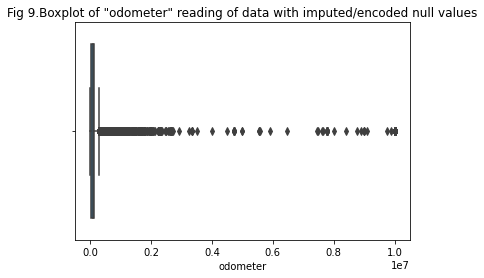

In [327]:
# boxplot of 'odometer' feature

sns.boxplot(data=DF_nan, x='odometer').set(title='Fig 9.Boxplot of "odometer" reading of data with imputed/encoded null values')
plt.savefig('fig 9.png')    
                                           

The odometer reading shows values that are above a million (1 * 10^6) miles.

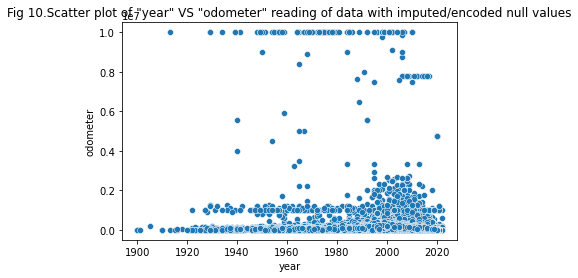

In [328]:
# scatter plot of the all odometer measurement against the year.

sns.scatterplot(data=DF_nan,x='year',y='odometer').set(title='Fig 10.Scatter plot of "year" VS "odometer" reading of data with imputed/encoded null values')
plt.savefig('fig 10.png')    
                                           

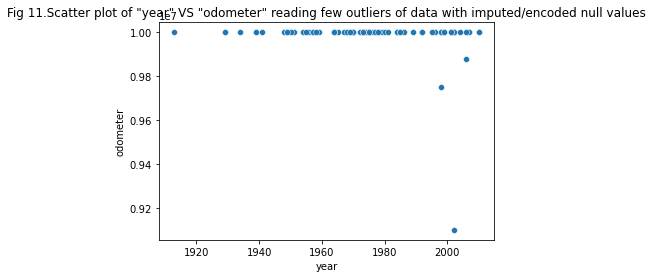

In [329]:
# plotting a scatter plot of the odometer numbers for all odometer measurements which are greater than 90%
# of the maximum odometer value vs year. ( 9 - 10Million)

sns.scatterplot(data=DF_nan[DF_nan['odometer']>(0.9*(DF_nan['odometer'].max()))],x='year',y='odometer').set(title='Fig 11.Scatter plot of "year" VS "odometer" reading few outliers of data with imputed/encoded null values')
plt.savefig('fig 11.png')    
                                           

In [330]:
DF_nan['odometer'].max()

10000000.0

We have very few vehicles that have values of odometer reading of 90% of maximum reading to the maximum reading of odometer in the dataset. However the maximum reading of odometer of the dataset is 10 Million. 

Based on "https://www.everlance.com/blog/10-highest-mileage-vehicles" we see that vehicles have much lesser than 1 Million miles while our data has observation where 'odometer' reading is also in Billions of miles. Hence we decided to truncate these outliers/possibly erroneuous data to less than 1 Million miles.

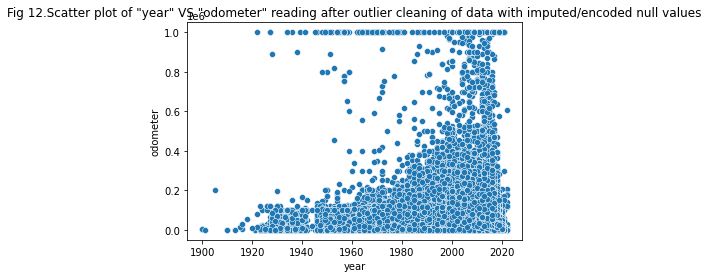

In [331]:
# plotting a scatter plot of the odometer numbers for all odometer measurements which are lesser than 10%
# of the maximum odometer (10 M) value vs year. (0-1Million)

sns.scatterplot(data=DF_nan[DF_nan['odometer']<(0.1*(DF_nan['odometer'].max()))],x='year',y='odometer').set(title='Fig 12.Scatter plot of "year" VS "odometer" reading after outlier cleaning of data with imputed/encoded null values')
plt.savefig('fig 12.png')    
                                           

We still see there are vehicles that have a 1M odometer reading although the number of datapoints in considerably less than the vehicles with odometer reading of 700K to 600K

In [332]:
# FIniding the value of 7% of maximum value (10M)
0.07*DF_nan['odometer'].max()

700000.0000000001

In [333]:
# Finding the number of observations that are above 7% of the maximum value(10M)

DF_nan.loc[DF_nan['odometer']> (0.07* DF_nan['odometer'].max())]

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
401,29,22500,1929.0,13,0,0,3,9999999.0,1,1,0,0,4,1
498,29,27990,2014.0,34,2,4,1,2222222.0,1,1,2,10,11,1
545,29,17990,2018.0,13,2,4,3,1111111.0,1,1,1,5,2,1
994,29,35000,1978.0,39,4,5,3,1000000.0,1,2,2,5,9,1
1276,29,15000,2003.0,41,4,0,1,1000000.0,1,2,0,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371846,216,14500,2008.0,13,3,0,3,1000000.0,1,1,0,0,4,48
372292,216,59900,2000.0,13,0,4,5,854000.0,1,2,3,0,9,48
372312,216,52000,1996.0,13,0,4,5,840000.0,1,2,3,0,9,48
373414,216,19500,2010.0,13,0,0,1,900132.0,1,2,0,0,11,48


In [334]:
# Finding the number of observations that are above 5% of the maximum value(10M)

DF_nan.loc[DF_nan['odometer']> (0.05* DF_nan['odometer'].max())]

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
401,29,22500,1929.0,13,0,0,3,9999999.0,1,1,0,0,4,1
498,29,27990,2014.0,34,2,4,1,2222222.0,1,1,2,10,11,1
545,29,17990,2018.0,13,2,4,3,1111111.0,1,1,1,5,2,1
994,29,35000,1978.0,39,4,5,3,1000000.0,1,2,2,5,9,1
1276,29,15000,2003.0,41,4,0,1,1000000.0,1,2,0,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372618,216,82000,2017.0,13,4,0,1,535000.0,1,3,0,10,1,48
373132,216,79000,2015.0,13,4,0,1,616239.0,1,2,0,0,8,48
373414,216,19500,2010.0,13,0,0,1,900132.0,1,2,0,0,11,48
374065,216,98000,2013.0,13,4,0,1,550000.0,1,2,0,0,4,48


There are only 1099 rows with values that are too high and are possibly result of outliers or data entry issues out of  376023 abservations. Dropping thse observation constitutes to loss of ~0.5 % data points and hence we can drop these observations for better model performance.(374924 observation remaining).

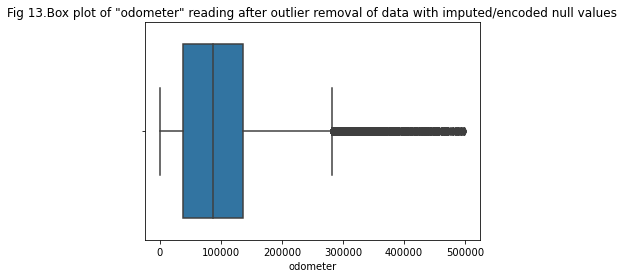

In [335]:
# Box plot of odometer reading that is less than 5% of the maximum value (10M)

sns.boxplot(data=(DF_nan[DF_nan['odometer']<(0.05*(DF_nan['odometer'].max()))]), x='odometer').set(title='Fig 13.Box plot of "odometer" reading after outlier removal of data with imputed/encoded null values')
plt.savefig('fig 13.png')    
                                           

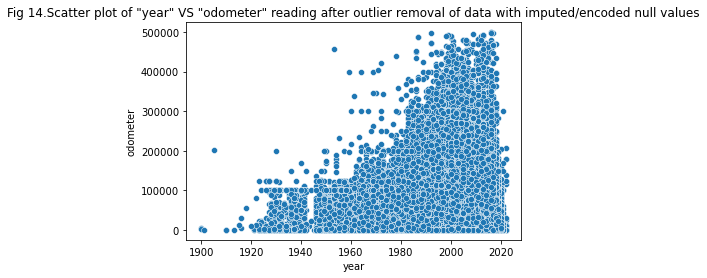

In [336]:
# Scatter plot of odometer reading that is less than 5% of the maximum value (10M)

sns.scatterplot(data=DF_nan[DF_nan['odometer']<(0.05*(DF_nan['odometer'].max()))],x='year',y='odometer').set(title='Fig 14.Scatter plot of "year" VS "odometer" reading after outlier removal of data with imputed/encoded null values')
plt.savefig('fig 14.png')    
                                           

Hence, we conclude from the analysis that creating a dataframe (DF_nan_odo) with odometer values that are less than 5% of the maximum odometer reading (10 M) could be used to conduct model building. 
Such a datframe has values of odometer reading that are too high, which, might have be caused by data-entry issues, removed.

### DATAFRAME 2 : DF

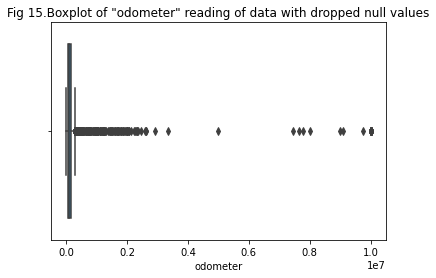

In [337]:
# boxplot of 'odometer' feature

sns.boxplot(data=DF, x='odometer').set(title='Fig 15.Boxplot of "odometer" reading of data with dropped null values')
plt.savefig('fig 15.png')    
                                         

The odometer reading shows values that are above a million (1 * 10^6) miles.

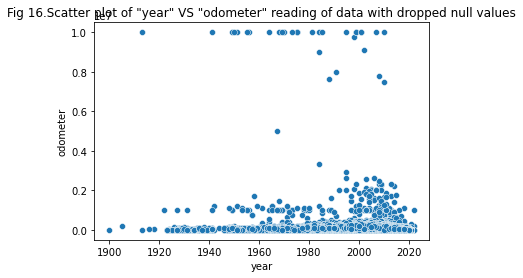

In [338]:
# scatter plot of the all odometer measurement against the year.

sns.scatterplot(data=DF,x='year',y='odometer').set(title='Fig 16.Scatter plot of "year" VS "odometer" reading of data with dropped null values')
plt.savefig('fig 16.png')    
                                           

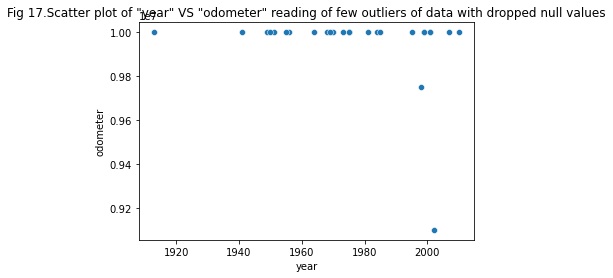

In [339]:
# plotting a scatter plot of the odometer numbers for all odometer measurements which are greater than 90%
# of the maximum odometer value vs year. (9-10 Million)

sns.scatterplot(data=DF[DF['odometer']>(0.9*(DF['odometer'].max()))],x='year',y='odometer').set(title='Fig 17.Scatter plot of "year" VS "odometer" reading of few outliers of data with dropped null values')
plt.savefig('fig 17.png')    
                                           

In [340]:
DF['odometer'].max()

10000000.0

We have very few vehicles that have values of odometer reading of 90% of maximum reading to the maximum reading of odometer in the dataset. However the maximum reading of odometer of the dataset is 10 Million. 

Based on "https://www.everlance.com/blog/10-highest-mileage-vehicles" we see that vehicles have much lesser than 1 Million miles while our data has observation where 'odometer' reading is also in Billions of miles. Hence we decided to truncate these outliers/possibly erroneuous data to less than 1 Million miles.

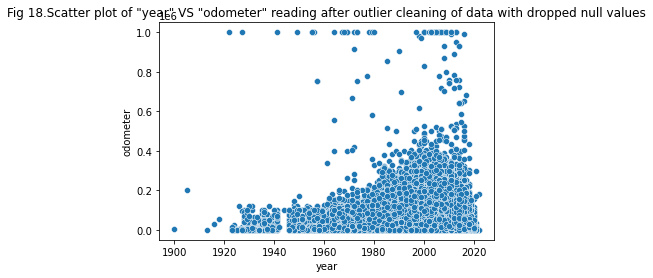

In [341]:
# plotting a scatter plot of the odometer numbers for all odometer measurements which are lesser than 10%
# of the maximum odometer (10 M) value vs year. (0-1Million)

sns.scatterplot(data=DF[DF['odometer']<(0.1*(DF['odometer'].max()))],x='year',y='odometer').set(title='Fig 18.Scatter plot of "year" VS "odometer" reading after outlier cleaning of data with dropped null values')
plt.savefig('fig 18.png')    

We still see there are vehicles that have a 1M odometer reading although the number of data points is considerably less than the vehicles with odometer reading of above 500k.

In [342]:
# Finding the number of observations that are above 5% of the maximum value(10M)

DF.loc[DF['odometer']> (0.05* DF['odometer'].max())]

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
130,29,27990,2014.0,34,3,5,0,2222222.0,0,0,0,10,10,1
153,29,17990,2018.0,13,3,5,2,1111111.0,0,0,1,0,1,1
284,29,35000,1978.0,39,2,6,2,1000000.0,0,1,0,0,8,1
677,151,23000,1967.0,7,2,6,2,999999.0,0,0,2,10,8,1
2206,107,1895,2000.0,7,2,5,2,999999.0,0,0,1,5,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106202,11,28750,2015.0,41,2,5,0,586692.0,0,1,2,10,10,48
106826,95,11000,1990.0,13,0,6,2,905000.0,0,0,2,2,4,48
107173,130,39500,1958.0,7,2,6,2,1710000.0,0,0,2,3,8,48
107536,168,5475,2008.0,10,0,3,2,930128.0,0,0,1,4,6,48


There are only 253 rows with values that are too high and are possibly result of outliers or data entry issues out of  109998 abservations. Dropping thse observation constitutes to loss of ~0.3 % data points and hence we can drop these observations for better model performance.(109745 observations remain).

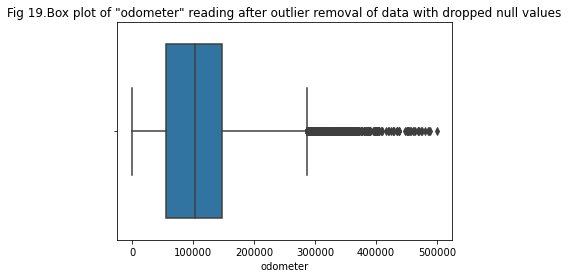

In [343]:
# Box plot of odometer reading that is less than 5% of the maximum value (10M)

sns.boxplot(data=(DF[DF['odometer']<(0.05*(DF['odometer'].max()))]), x='odometer').set(title='Fig 19.Box plot of "odometer" reading after outlier removal of data with dropped null values')
plt.savefig('fig 19.png')    
                                           

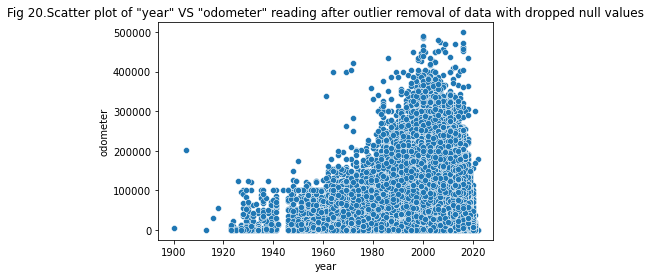

In [344]:
# Scatter plot of odometer reading that is less than 5% of the maximum value (10M)

sns.scatterplot(data=DF[DF['odometer']<(0.05*(DF['odometer'].max()))],x='year',y='odometer').set(title='Fig 20.Scatter plot of "year" VS "odometer" reading after outlier removal of data with dropped null values')
plt.savefig('fig 20.png')    
                                           

Hence, we conclude from the analysis that creating a dataframe (DF_nan_odo) with odometer values that are less than 5% of the maximum odometer reading (10 M) could be used to conduct model building. 
Such a datframe has values of odometer reading that are too high, which, might have be caused by data-entry issues, removed.

#### 3.2. Construction of Final Dataframe

### DATAFRAME 1 : DF_nan

In [345]:
# Subsetting DF_nan to DF_nan_odo that contains only tht odometer value between 0-500K

DF_nan_odo = DF_nan[ DF_nan['odometer'] <= (0.05*(DF_nan['odometer'].max())) ]

In [346]:
# Resetting the index for continous dataframe index of DF_nan_odo

DF_nan_odo = DF_nan_odo.reset_index(drop=True) 
"""setting drop=true ensures the previous index is dropped."""

'setting drop=true ensures the previous index is dropped.'

In [347]:
DF_nan_odo

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,16,33590,2014.0,14,4,5,3,57923.0,1,3,0,9,11,1
1,16,22590,2010.0,7,4,5,3,71229.0,1,3,0,9,2,1
2,16,39590,2020.0,7,4,5,3,19160.0,1,3,0,9,9,1
3,16,30990,2017.0,39,4,5,3,41124.0,1,3,0,9,9,1
4,16,15000,2013.0,13,3,4,3,128000.0,1,1,3,10,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374919,397,23590,2019.0,31,4,4,3,32226.0,1,3,1,3,4,50
374920,397,30590,2020.0,41,4,0,3,12029.0,1,3,1,3,9,50
374921,397,34990,2020.0,6,4,0,1,4174.0,1,3,0,2,11,50
374922,397,28990,2018.0,23,4,4,3,30112.0,1,3,1,3,10,50


### DATAFRAME 2 : DF

In [348]:
# Subsetting DF_nan to DF_nan_odo that contains only tht odometer value between 0-500K

DF_odo = DF[ DF['odometer'] <= (0.05*(DF['odometer'].max())) ]

In [349]:
# Resetting the index for continous dataframe index of DF_nan_odo

DF_odo = DF_odo.reset_index(drop=True) 
"""setting drop=true ensures the previous index is dropped."""

'setting drop=true ensures the previous index is dropped.'

In [350]:
DF_odo

,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,16,15000,2013.0,13,0,5,2,128000.0,0,0,2,10,0,1
1,16,27990,2012.0,14,2,6,2,68696.0,0,2,0,8,0,1
2,16,34590,2016.0,7,2,5,2,29499.0,0,2,0,8,9,1
3,16,35000,2019.0,39,0,5,2,43000.0,0,0,0,10,5,1
4,16,29990,2016.0,7,2,5,2,17302.0,0,2,0,8,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109740,396,48590,2020.0,6,2,5,2,7701.0,0,2,1,7,0,50
109741,396,39990,2017.0,18,2,6,2,41664.0,0,0,0,7,0,50
109742,396,32990,2016.0,18,2,6,2,55612.0,0,0,2,7,0,50
109743,396,33590,2018.0,23,2,5,2,30814.0,0,0,2,9,10,50


#### 3.3. Estimation Pearson's correlation co-effcient 

### DATAFRAME 1 : DF_nan_odo

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/2901045144.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(DF_nan_odo.corr(method='pearson'), dtype=np.bool))


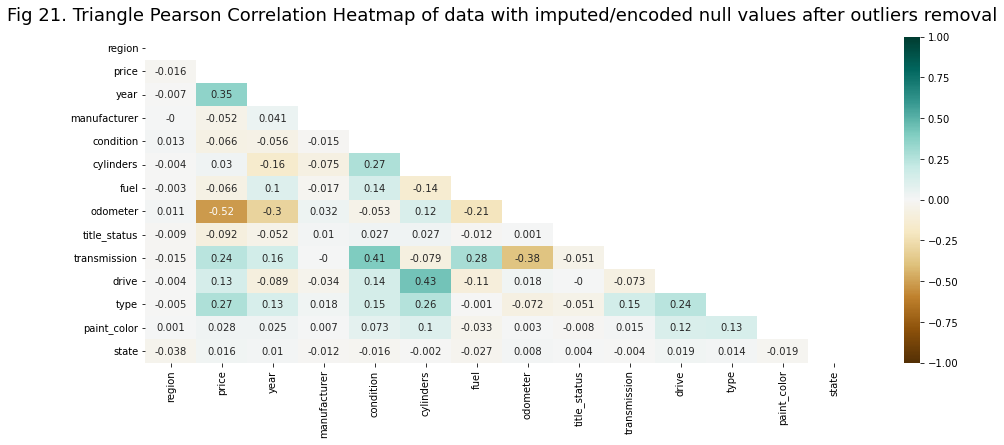

In [351]:
# Pearson Correlation Coefficient heatmap with numerical values 

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(DF_nan_odo.corr(method='pearson'), dtype=np.bool))
heatmap = sns.heatmap(round(DF_nan_odo.corr(),3), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Fig 21. Triangle Pearson Correlation Heatmap of data with imputed/encoded null values after outliers removal', fontdict={'fontsize':18}, pad=16);
plt.savefig('fig 21.png')


### DATAFRAME 2 : DF_odo

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/2397236323.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(DF_odo.corr(method='pearson'), dtype=np.bool))


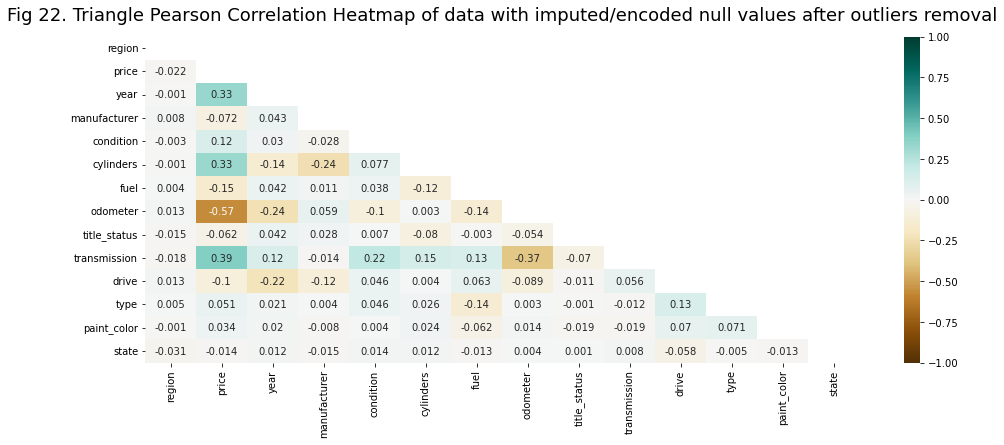

In [352]:
# Pearson Correlation Coefficient heatmap with numerical values 

plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(DF_odo.corr(method='pearson'), dtype=np.bool))
heatmap = sns.heatmap(round(DF_odo.corr(),3), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Fig 22. Triangle Pearson Correlation Heatmap of data with imputed/encoded null values after outliers removal', fontdict={'fontsize':18}, pad=16);
plt.savefig('fig 22.png')


### 4. Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### DATAFRAME 1 : DF_nan_odo

#### 4.1. Creating Training and Development data for modeling and model improvememnt

In [203]:
# split the data into training data and develoment data using 

X = DF_nan_odo.drop(columns = ['price'])
y = DF_nan_odo['price']
        
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [204]:
X_train.head().append(X_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/4211938313.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.head().append(X_train.tail())


,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
114477,33,2010.0,40,0,2,3,62772.0,1,1,1,5,9,13
218095,186,2014.0,8,4,4,3,85571.0,1,1,3,3,6,33
199510,27,2017.0,34,0,5,3,65700.0,1,1,2,10,4,26
71145,389,2006.0,7,0,4,3,193108.0,1,1,1,3,9,5
105379,14,2016.0,13,4,2,3,125100.0,1,1,1,0,4,10
259178,61,1994.0,29,0,2,1,207000.0,1,2,3,0,4,35
365838,130,2004.0,13,3,4,3,238000.0,1,1,1,7,2,48
131932,116,2019.0,4,4,0,3,25656.0,1,3,3,1,11,15
146867,204,1995.0,7,0,5,3,235000.0,1,1,2,10,11,16
121958,50,1965.0,13,5,5,3,5000.0,1,1,3,1,4,14


In [205]:
X_train.shape

(251199, 13)

In [206]:
y_train.head().append(y_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/3570967498.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train.head().append(y_train.tail())


114477     8995
218095     1500
199510    37998
71145      3950
105379     4900
259178     3295
365838     3495
131932    37590
146867     4500
121958     3000
Name: price, dtype: int64

In [207]:
# create the baseline for error analysis
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_dev = np.ones(shape = y_dev.shape)*y_dev.mean()

mae_baseline_train = mean_absolute_error(baseline_train, y_train)
mae_baseline_dev = mean_absolute_error(baseline_dev, y_dev)

mape_baseline_train = mean_absolute_percentage_error(baseline_train, y_train)
mape_baseline_dev = mean_absolute_percentage_error(baseline_dev, y_dev)

msle_baseline_train = mean_squared_log_error(baseline_train, y_train)
msle_baseline_dev = mean_squared_log_error(baseline_dev, y_dev)

In [208]:
#printing the baseline error
print('The mean absolute baseline training error is: ', mae_baseline_train)
print('The mean absolute baseline development error is: ', mae_baseline_dev)

print('The mean absolute percentage baseline training error is: ', mape_baseline_train)
print('The mean absolute percentage baseline development error is: ', mape_baseline_dev)

print('The mean squared log baseline training error is: ', msle_baseline_train)
print('The mean squared log baseline development error is: ', msle_baseline_dev)

The mean absolute baseline training error is:  11489.379276439351
The mean absolute baseline development error is:  11529.410553987955
The mean absolute percentage baseline training error is:  0.5889714867513697
The mean absolute percentage baseline development error is:  0.5908366718301473
The mean squared log baseline training error is:  0.7921694063430249
The mean squared log baseline development error is:  0.7964772211054767


#### 4.2 Model building

We use the same modeling strategy for the iteration 2 of CRISP-DM framework to evaluate the fitness of each model after outlier removal. We are specifically intrested to see the polynomial features Bayesian Ridge regression model performace and hence we have computed the R^2 values of all the model in this iteration. It is to be noted that the Bayesian ridge regression model with polynomial features has been the best model so far acroos both the data with and without dropped null values. 
All through the model building we perform permutation importance to select the features that are most deterministic of the price of the used cars. 

#### MODEL 5: Elastic Net regression, Recurssive feature elimination, gradient decent optimization,Permutation importance for feature selection

In [350]:
# scaling columns as aplha is sensitive to magnitude of feature

"""We use standard scalar to z = (x - u) / s, where u is the mean of the training samples or 
zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False."""

"""Standardization of a dataset is a common requirement for many machine learning estimators: 
they might behave badly if the individual features do not more or less look like standard normally distributed data 
(e.g. Gaussian with 0 mean and unit variance)."""

"""For instance many elements used in the objective function of a learning algorithm 
(such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) 
assume that all features are centered around 0 and have variance in the same order. """

"""If a feature has a variance that is orders of magnitude larger than others, 
it might dominate the objective function and make the estimator unable to learn 
from other features correctly as expected."""

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                        )
# Building pipe line for the selected model

pipeline5 = Pipeline([('prep', preprocessor),
                      ('selector',RFE(LinearRegression(),n_features_to_select=7)),
                      ('lossfunction', ElasticNet(alpha=.1, positive= True, random_state = 42, fit_intercept=False))])
pipeline5.fit(X_train,y_train)
                      

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('selector',
                 RFE(estimator=LinearRegression(), n_features_to_select=7)),
                ('lossfunction',
                 ElasticNet(alpha=0.1, fit_intercept=False, positive=True,
                            random_state=42))])

In [362]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline5, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

transmission0.100 +/- 0.001
type    0.100 +/- 0.001
drive   0.029 +/- 0.001


In [365]:
pipeline5.score(X_dev,y_dev)

0.08661336618509685

In [351]:
train_preds = pipeline5.predict(X_train)
dev_preds = pipeline5.predict(X_dev)
pipeline5_train_mae = mean_absolute_error(y_train, train_preds)
pipeline5_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline5_train_mae)
print('The mean absolute testing error is: ', pipeline5_dev_mae)

The mean absolute training error is:  10033.615137113795
The mean absolute testing error is:  10086.29342552394


In [352]:
pipeline5_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline5_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline5_train_mape)
print('MAPE Dev is: ', pipeline5_dev_mape)

MAPE Train is:  1.0058213001734089
MAPE Dev is:  1.0135463246021457


In [353]:
pipeline1_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline1_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline1_train_msle)
print('MSLE Dev is: ', pipeline1_dev_msle)

MSLE Train is:  0.6641461486999101
MSLE Dev is:  0.670604726371612


In [354]:
min(train_preds)

7177.359617011976

In [355]:
min(dev_preds)

7177.359617011976

#### MODEL 6: Polynomial regression, elasticnet regression, gradient decent optimization, Manual hyperparameter optimization, Permutation importance for feature selection

In [356]:
# Create a pipeline model with the best alpha to select features

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                        )

pipeline6 = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ElasticNet(alpha= .10, positive= True, random_state = 42, fit_intercept=False))
                     ])

pipeline6.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 ElasticNet(alpha=0.1, fit_intercept=False, positive=True,
                            random_state=42))])

In [363]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline6, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

type    0.101 +/- 0.001
transmission0.090 +/- 0.001
drive   0.024 +/- 0.001
year    0.009 +/- 0.000
cylinders0.003 +/- 0.000
state   0.002 +/- 0.000
fuel    0.000 +/- 0.000


In [364]:
pipeline6.score(X_dev,y_dev)

0.1486385830274144

In [357]:
train_preds = pipeline6.predict(X_train)
dev_preds = pipeline6.predict(X_dev)
pipeline6_train_mae = mean_absolute_error(y_train, train_preds)
pipeline6_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline6_train_mae)
print('The mean absolute testing error is: ', pipeline6_dev_mae)

The mean absolute training error is:  9937.307547429982
The mean absolute testing error is:  9975.665124354364


In [358]:
pipeline6_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline6_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline6_train_mape)
print('MAPE Dev is: ', pipeline6_dev_mape)

MAPE Train is:  1.062721474399064
MAPE Dev is:  1.0685514910921314


In [359]:
pipeline6_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline6_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline6_train_msle)
print('MSLE Dev is: ', pipeline6_dev_msle)

MSLE Train is:  0.6548024221804494
MSLE Dev is:  0.6594871186258878


In [360]:
min(train_preds)

11846.063813685403

In [361]:
min(dev_preds)

11947.671512794463

#### MODEL 6a: Polynomial degree, BaysianARD regression, gradient decent optimization, Manual hyperparameter optimization, Permutation importance for feature selection

In [385]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline6a = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ARDRegression(fit_intercept=False, alpha_1=.1e-9, lambda_1=.1e-9))
                     ])
                    
pipeline6a.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 ARDRegression(alpha_1=1e-10, fit_intercept=False,
                               lambda_1=1e-10))])

In [386]:
pipeline6a.score(X_dev,y_dev)

0.3835835771468379

In [387]:
train_preds = pipeline6a.predict(X_train)
dev_preds = pipeline6a.predict(X_dev)
pipeline6a_train_mae = mean_absolute_error(y_train, train_preds)
pipeline6a_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline6a_train_mae)
print('The mean absolute testing error is: ', pipeline6a_dev_mae)

The mean absolute training error is:  7624.5395480847255
The mean absolute testing error is:  7643.922054236103


In [388]:
pipeline6a_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline6a_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline6a_train_mape)
print('MAPE Dev is: ', pipeline6a_dev_mape)

MAPE Train is:  0.6523540734303567
MAPE Dev is:  0.6536185467755791


In [390]:
train_preds_noneg = train_preds[train_preds>0]
y_train_noneg = y_train[train_preds>0]
dev_preds_noneg = dev_preds[dev_preds>0]
y_dev_noneg = y_dev[dev_preds>0]

pipeline6a_train_msle = mean_squared_log_error(train_preds_noneg, y_train_noneg)
pipeline6a_dev_msle = mean_squared_log_error(dev_preds_noneg, y_dev_noneg)

print('MSLE Train is: ', pipeline6a_train_msle)
print('MSLE Dev is: ', pipeline6a_dev_msle)

MSLE Train is:  0.4765094360783019
MSLE Dev is:  0.4807243019863575


In [391]:
min(train_preds)

-12596.841574093927

In [392]:
min(dev_preds)

-14024.558605177444

In [ ]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline6a, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Since we are getting negative values in our predictions using the model, we can use tranformation on the taget variable, we can do logarithimic transformation to avoid this negative prediction as a future step. 

#### MODEL 6b: Polynomial degree, BaysianRidge regression, gradient decent optimization,Permutation importance for feature selection

In [ ]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline6b = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', BayesianRidge(fit_intercept=False))
                     ])
                    
pipeline6b.fit(X_train,y_train)

In [394]:
pipeline6b.score(X_dev,y_dev)

0.6803612507003056

In [395]:
train_preds = pipeline6b.predict(X_train)
dev_preds = pipeline6b.predict(X_dev)
pipeline6b_train_mae = mean_absolute_error(y_train, train_preds)
pipeline6b_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline6b_train_mae)
print('The mean absolute testing error is: ', pipeline6b_dev_mae)

The mean absolute training error is:  5293.09142468564
The mean absolute testing error is:  5338.691608751807


In [396]:
pipeline6b_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline6b_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline6b_train_mape)
print('MAPE Dev is: ', pipeline6b_dev_mape)

MAPE Train is:  0.4675667930171926
MAPE Dev is:  0.47004966684737626


In [397]:
train_preds_noneg = train_preds[train_preds>0]
y_train_noneg = y_train[train_preds>0]
dev_preds_noneg = dev_preds[dev_preds>0]
y_dev_noneg = y_dev[dev_preds>0]

pipeline6b_train_msle = mean_squared_log_error(train_preds_noneg, y_train_noneg)
pipeline6b_dev_msle = mean_squared_log_error(dev_preds_noneg, y_dev_noneg)

print('MSLE Train is: ', pipeline6b_train_msle)
print('MSLE Dev is: ', pipeline6b_dev_msle)

MSLE Train is:  0.28419773833277057
MSLE Dev is:  0.2848865084194402


In [398]:
min(train_preds)

-36580.0286141634

In [399]:
min(dev_preds)

-46136.804722987115

In [402]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline6b, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

year    0.322 +/- 0.002
odometer0.271 +/- 0.002
fuel    0.149 +/- 0.001
cylinders0.097 +/- 0.001
drive   0.071 +/- 0.001
condition0.036 +/- 0.001
type    0.029 +/- 0.000
transmission0.028 +/- 0.001
manufacturer0.012 +/- 0.000
title_status0.012 +/- 0.000
paint_color0.005 +/- 0.000
state   0.003 +/- 0.000
region  0.001 +/- 0.000


Since we are getting negative values in our predictions using the model, we can use tranformation on the taget variable, we can do logarithimic transformation to avoid this negative prediction as a future step. 

In [ ]:
len(train_preds[train_preds<0])

#### Evaluation ####
In the second iteration of CRISP-DM framework , for the data set with imputed/encoded null values and removed/addressed outliers, bayesian Rdge regression model with polynomial features performs the best to express that data set with R^2 value of .68. The MAE (5338.7), MAPE(0.47), and MSLE(0.29) were about 50%, 20%, 70% less than the baseline error values. These are comparable to the error values we got without outlier removal as well. However, the difference lies in the minimum predicted values, which still have negative values, but are much closer to zero (from -100K to -35K) than before outlier removal. 

We still have to address the negative predictions of the model. We can do this through logarithmic transformation of the price in the next iteration of CRISP-DM frame work. 

Although, we have determined the important features as described by this model, we would like to fine tune this model to predict only positive values and compare the features expressed in that model with the perason correlation plots of the two data sets (with and without null value dropping) and the with the features indicated by the best model of the dataset with dropped null values to arrive at the final recommendation.  

### DATAFRAME 2 : DF_odo

#### 4.3. Creating Training and Development data for modeling and model improvememnt

In [90]:
# split the data into training data and develoment data using 

X = DF_odo.drop(columns = ['price'])
y = DF_odo['price']
        
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [91]:
X_train.head().append(X_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_3361/4211938313.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.head().append(X_train.tail())


,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
57598,38,2013.0,37,0,3,2,132688.0,0,0,0,8,10,26
88342,391,2014.0,13,0,3,3,164000.0,0,0,1,9,10,38
19143,112,2007.0,37,2,3,2,102000.0,0,0,0,0,9,5
4500,105,2004.0,14,2,6,2,199000.0,0,0,0,0,0,2
51118,128,2017.0,40,0,3,2,41000.0,0,1,1,9,0,22
54886,216,2007.0,16,2,5,2,187000.0,0,0,1,11,2,23
76820,61,2008.0,16,0,3,2,142819.0,0,0,1,9,5,35
103694,288,2010.0,16,3,3,2,105731.0,0,0,1,4,5,45
860,151,2020.0,7,2,6,2,12880.0,0,0,0,8,10,1
15795,350,2006.0,13,0,5,2,145312.0,0,1,0,8,5,4


In [92]:
X_train.shape

(73529, 13)

In [93]:
y_train.head().append(y_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_3361/3570967498.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train.head().append(y_train.tail())


57598      8400
88342      7995
19143      6900
4500       5200
51118     14995
54886      4899
76820      5199
103694     5990
860       41990
15795     13999
Name: price, dtype: int64

In [94]:
# create the baseline for error analysis
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_dev = np.ones(shape = y_dev.shape)*y_dev.mean()

mae_baseline_train = mean_absolute_error(baseline_train, y_train)
mae_baseline_dev = mean_absolute_error(baseline_dev, y_dev)

mape_baseline_train = mean_absolute_percentage_error(baseline_train, y_train)
mape_baseline_dev = mean_absolute_percentage_error(baseline_dev, y_dev)

msle_baseline_train = mean_squared_log_error(baseline_train, y_train)
msle_baseline_dev = mean_squared_log_error(baseline_dev, y_dev)

In [95]:
#printing the baseline error
print('The mean absolute baseline training error is: ', mae_baseline_train)
print('The mean absolute baseline development error is: ', mae_baseline_dev)

print('The mean absolute percentage baseline training error is: ', mape_baseline_train)
print('The mean absolute percentage baseline development error is: ', mape_baseline_dev)

print('The mean squared log baseline training error is: ', msle_baseline_train)
print('The mean squared log baseline development error is: ', msle_baseline_dev)

The mean absolute baseline training error is:  10380.099567036323
The mean absolute baseline development error is:  10316.746955829449
The mean absolute percentage baseline training error is:  0.6349775822531026
The mean absolute percentage baseline development error is:  0.6348811102533882
The mean squared log baseline training error is:  0.8097739427337933
The mean squared log baseline development error is:  0.8119458510253174


#### 4.4. Model building

We use the same modeling strategy for the iteration 2 of CRISP-DM framework to evaluate the fitness of each model after outlier removal as we did for the dataset with outlier imputation/encoding.For this dataset as well, we are specifically intrested to see the polynomial features Bayesian Ridge regression model performace and hence we have computed the R^2 values of all the model in this iteration. It is to be noted that the Bayesian ridge regression model with polynomial features has been the best model so far acroos both the data with and without dropped null values. 
All through the model building we perform permutation importance to select the features that are most deterministic of the price of the used cars.

#### MODEL 7: Elastic Net regression, Recurssive feature elimination, gradient decent optimization,Permutation importance for feature selection

In [108]:
# scaling columns as aplha is sensitive to magnitude of feature

"""We use standard scalar to z = (x - u) / s, where u is the mean of the training samples or 
zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False."""

"""Standardization of a dataset is a common requirement for many machine learning estimators: 
they might behave badly if the individual features do not more or less look like standard normally distributed data 
(e.g. Gaussian with 0 mean and unit variance)."""

"""For instance many elements used in the objective function of a learning algorithm 
(such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) 
assume that all features are centered around 0 and have variance in the same order. """

"""If a feature has a variance that is orders of magnitude larger than others, 
it might dominate the objective function and make the estimator unable to learn 
from other features correctly as expected."""

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                        )
# Building pipe line for the selected model

pipeline7 = Pipeline([('prep', preprocessor),
                      ('selector',RFE(LinearRegression(),n_features_to_select=9)),
                      ('lossfunction', ElasticNet(alpha=.01, positive= True, random_state = 42, fit_intercept=False))])
pipeline7.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('selector',
                 RFE(estimator=LinearRegression(), n_features_to_select=9)),
                ('lossfunction',
                 ElasticNet(alpha=0.01, fit_intercept=False, positive=True,
                            random_state=42))])

In [109]:
pipeline7.score(X_dev,y_dev)

0.22457503360413666

In [110]:
train_preds = pipeline7.predict(X_train)
dev_preds = pipeline7.predict(X_dev)
pipeline7_train_mae = mean_absolute_error(y_train, train_preds)
pipeline7_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline7_train_mae)
print('The mean absolute testing error is: ', pipeline7_dev_mae)

The mean absolute training error is:  8465.070656013197
The mean absolute testing error is:  8459.077242057716


In [111]:
pipeline7_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline7_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline7_train_mape)
print('MAPE Dev is: ', pipeline7_dev_mape)

MAPE Train is:  1.0642434443770252
MAPE Dev is:  1.0794412400928726


In [112]:
pipeline7_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline7_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline7_train_msle)
print('MSLE Dev is: ', pipeline7_dev_msle)

MSLE Train is:  0.6848548355677488
MSLE Dev is:  0.6924789591248567


In [113]:
min(train_preds)

645.2108054989222

In [114]:
min(dev_preds)

645.5335722850648

In [115]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline7, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

transmission0.230 +/- 0.004
cylinders0.144 +/- 0.002
paint_color0.002 +/- 0.000
condition0.002 +/- 0.000
year    0.000 +/- 0.000


#### MODEL 8: Polynomial regression, elasticnet regression, gradient decent optimization, Manual hyperparameter optimization, Permutation importance for feature selection

In [116]:
# Create a pipeline model with the best alpha to select features

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                        )

pipeline8 = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ElasticNet(alpha= .10, positive= True, random_state = 42, fit_intercept=False))
                     ])

pipeline8.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 ElasticNet(alpha=0.1, fit_intercept=False, positive=True,
                            random_state=42))])

In [117]:
pipeline8.score(X_dev,y_dev)

0.277287656040358

In [118]:
train_preds = pipeline8.predict(X_train)
dev_preds = pipeline8.predict(X_dev)
pipeline8_train_mae = mean_absolute_error(y_train, train_preds)
pipeline8_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline8_train_mae)
print('The mean absolute testing error is: ', pipeline8_dev_mae)

The mean absolute training error is:  8026.037738993364
The mean absolute testing error is:  8024.512184826831


In [120]:
pipeline8_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline8_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline8_train_mape)
print('MAPE Dev is: ', pipeline8_dev_mape)

MAPE Train is:  1.007415259117966
MAPE Dev is:  1.0214299741083814


In [121]:
pipeline8_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline8_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline8_train_msle)
print('MSLE Dev is: ', pipeline8_dev_msle)

MSLE Train is:  0.6213200248961449
MSLE Dev is:  0.6287627508164118


In [122]:
min(train_preds)

7035.1041747282

In [123]:
min(dev_preds)

7007.395087407523

In [124]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline8, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

transmission0.256 +/- 0.004
cylinders0.162 +/- 0.002
condition0.017 +/- 0.001
type    0.006 +/- 0.001
year    0.005 +/- 0.000
paint_color0.005 +/- 0.000
odometer0.004 +/- 0.000
manufacturer0.001 +/- 0.000
fuel    0.000 +/- 0.000


#### MODEL 8a: Polynomial degree, BaysianARD regression, gradient decent optimization, Manual hyperparameter optimization, Permutation importance for feature selection

In [125]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline8a = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', ARDRegression(fit_intercept=False, alpha_1=.1e-9, lambda_1=.1e-9))
                     ])
                    
pipeline8a.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction',
                 ARDRegression(alpha_1=1e-10, fit_intercept=False,
                               lambda_1=1e-10))])

In [126]:
pipeline8a.score(X_dev,y_dev)

0.5835583655671108

In [127]:
train_preds = pipeline8a.predict(X_train)
dev_preds = pipeline8a.predict(X_dev)
pipeline8a_train_mae = mean_absolute_error(y_train, train_preds)
pipeline8a_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline8a_train_mae)
print('The mean absolute testing error is: ', pipeline8a_dev_mae)

The mean absolute training error is:  5870.325140499691
The mean absolute testing error is:  5831.485506068007


In [128]:
pipeline8a_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline8a_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline8a_train_mape)
print('MAPE Dev is: ', pipeline8a_dev_mape)

MAPE Train is:  0.6546321134872448
MAPE Dev is:  0.6575012567645299


In [129]:
train_preds_noneg = train_preds[train_preds>0]
y_train_noneg = y_train[train_preds>0]
dev_preds_noneg = dev_preds[dev_preds>0]
y_dev_noneg = y_dev[dev_preds>0]

pipeline8a_train_msle = mean_squared_log_error(train_preds_noneg, y_train_noneg)
pipeline8a_dev_msle = mean_squared_log_error(dev_preds_noneg, y_dev_noneg)

print('MSLE Train is: ', pipeline8a_train_msle)
print('MSLE Dev is: ', pipeline8a_dev_msle)

MSLE Train is:  0.42572524944424334
MSLE Dev is:  0.4320745461938363


In [130]:
min(train_preds)

-15614.559207779741

In [131]:
min(dev_preds)

-12390.094271376198

In [132]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline8a, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

odometer0.592 +/- 0.005
cylinders0.127 +/- 0.002
drive   0.077 +/- 0.002
fuel    0.064 +/- 0.001
transmission0.046 +/- 0.001
type    0.022 +/- 0.001
condition0.019 +/- 0.001
title_status0.008 +/- 0.000
paint_color0.004 +/- 0.000
year    0.003 +/- 0.000
manufacturer0.002 +/- 0.001


#### MODEL 8b: Polynomial degree, BaysianRidge regression, gradient decent optimization,Permutation importance for feature selection

In [133]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline8b = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=False)),
                      ('lossfunction', BayesianRidge(fit_intercept=False))
                     ])
                    
pipeline8b.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('lossfunction', BayesianRidge(fit_intercept=False))])

In [134]:
pipeline8b.score(X_dev,y_dev)

0.7693997324767716

In [135]:
train_preds = pipeline8b.predict(X_train)
dev_preds = pipeline8b.predict(X_dev)
pipeline8b_train_mae = mean_absolute_error(y_train, train_preds)
pipeline8b_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline8b_train_mae)
print('The mean absolute testing error is: ', pipeline8b_dev_mae)

The mean absolute training error is:  3947.52508553238
The mean absolute testing error is:  3980.434215137863


In [136]:
pipeline8b_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline8b_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline8b_train_mape)
print('MAPE Dev is: ', pipeline8b_dev_mape)

MAPE Train is:  0.3890740693167666
MAPE Dev is:  0.39773059335853095


In [137]:
train_preds_noneg = train_preds[train_preds>0]
y_train_noneg = y_train[train_preds>0]
dev_preds_noneg = dev_preds[dev_preds>0]
y_dev_noneg = y_dev[dev_preds>0]

pipeline8b_train_msle = mean_squared_log_error(train_preds_noneg, y_train_noneg)
pipeline8b_dev_msle = mean_squared_log_error(dev_preds_noneg, y_dev_noneg)

print('MSLE Train is: ', pipeline8b_train_msle)
print('MSLE Dev is: ', pipeline8b_dev_msle)

MSLE Train is:  0.21821333719072158
MSLE Dev is:  0.22503960531548084


In [138]:
min(train_preds)

-14451.242885135114

In [139]:
min(dev_preds)

-14843.199721477926

In [141]:
len(train_preds[train_preds<0])

436

In [142]:
# Details of negative predictions
X_train[train_preds<0]

,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
88317,391,1999.0,0,2,5,2,165000.0,0,0,1,9,9,38
86194,267,2000.0,16,2,3,2,134500.0,0,0,0,0,10,38
89945,109,2016.0,13,2,0,2,360000.0,1,0,2,10,10,40
16021,373,2003.0,10,5,6,2,257800.0,5,0,2,10,1,4
62554,394,1996.0,13,2,5,2,76000.0,0,0,1,9,4,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89930,65,1982.0,34,2,6,2,98000.0,0,0,2,11,5,40
54098,204,1998.0,5,2,3,2,160000.0,0,0,0,7,3,23
104182,24,1985.0,6,2,6,2,103164.0,0,0,1,9,8,47
68840,42,1991.0,14,2,5,2,163580.0,0,0,2,11,1,34


In [143]:
# original price of negatively predicted price observations
y_train[train_preds<0]

88317      3500
86194      3500
89945     25000
16021      2600
62554      2500
          ...  
89930      2500
54098      1900
104182     9500
68840      3000
82386      7500
Name: price, Length: 436, dtype: int64

In [140]:
# Using Premutation importance for selecting features

r = permutation_importance(pipeline8b, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

year    0.359 +/- 0.004
odometer0.334 +/- 0.004
cylinders0.195 +/- 0.003
drive   0.107 +/- 0.002
fuel    0.088 +/- 0.001
transmission0.035 +/- 0.001
type    0.025 +/- 0.001
title_status0.024 +/- 0.001
manufacturer0.018 +/- 0.001
condition0.015 +/- 0.001
state   0.004 +/- 0.000
paint_color0.003 +/- 0.000


#### Evaluation ####
In the second iteration of CRISP-DM framework , for the data set with dropped null values and removed/addressed outliers, bayesian Rdge regression model with polynomial features performs the best to express that data set with R^2 value of .79, that indicates that the model is a good fit for the dataset it has been built on. The MAE (3980.4), MAPE(0.39), and MSLE(0.23) were about 65%, 40%, 60% less than the baseline error values. These are the least errors and most lower than the baseline errors that we have obtained so far through all the models that we constructed. However, the difference lies in the minimum predicted values, which still have negative values, but are much closer to zero (from -100K to -15K) than before outlier removal. 

We still have to address the negative predictions of the model. We can do this through logarithmic transformation of the price in the next iteration of CRISP-DM frame work. It is also to be noted that since we have obtained the best model so far for the data set with dropped null values, it could be a useful reccomendation to the car dealers to do proper data-entry fo their inventory to make better predictions from their business. 

Although, we have determined the important features as described by this model, we would like to fine tune this model to predict only positive values and compare the features expressed in that model with the perason correlation plots of the two data sets (with and without null value dropping) and the with the features indicated by the best model of the dataset with dropped null values to arrive at the final recommendation.  


## ITERATION 3 OF CRISP-DM FRAMEWORK

We will now begin direclty with step 4 of data modeling and evaluation in the CRISP-DM framework, as we have found the best model for our data sets from the previous two iterations, i.e. Bayesian Ridge regression with polynomial features followed by permutation importance to find the most important feautures affecting the price of used cars. 

In this iteration (3) we transform the target variable 'price' using a logarithmic transformation and fit and predict it using the best model from the previous iterations which is the bayesian ridge regression with polynomial features.

### 4. Modeling and Evaluation

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### DATAFRAME 1 : DF_nan_odo

#### 4.1. Creating Training and Development data for modeling and model improvement

In [353]:
# split the data into training data and develoment data using 

X = DF_nan_odo.drop(columns = ['price'])
y = DF_nan_odo['price']
        
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [354]:
X_train.head().append(X_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/4211938313.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.head().append(X_train.tail())


,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
114477,33,2010.0,40,0,2,3,62772.0,1,1,1,5,9,13
218095,186,2014.0,8,4,4,3,85571.0,1,1,3,3,6,33
199510,27,2017.0,34,0,5,3,65700.0,1,1,2,10,4,26
71145,389,2006.0,7,0,4,3,193108.0,1,1,1,3,9,5
105379,14,2016.0,13,4,2,3,125100.0,1,1,1,0,4,10
259178,61,1994.0,29,0,2,1,207000.0,1,2,3,0,4,35
365838,130,2004.0,13,3,4,3,238000.0,1,1,1,7,2,48
131932,116,2019.0,4,4,0,3,25656.0,1,3,3,1,11,15
146867,204,1995.0,7,0,5,3,235000.0,1,1,2,10,11,16
121958,50,1965.0,13,5,5,3,5000.0,1,1,3,1,4,14


In [355]:
X_train.shape

(251199, 13)

In [356]:
y_train.head().append(y_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/3570967498.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train.head().append(y_train.tail())


114477     8995
218095     1500
199510    37998
71145      3950
105379     4900
259178     3295
365838     3495
131932    37590
146867     4500
121958     3000
Name: price, dtype: int64

In [357]:
# create the baseline for error analysis
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_dev = np.ones(shape = y_dev.shape)*y_dev.mean()

mae_baseline_train = mean_absolute_error(baseline_train, y_train)
mae_baseline_dev = mean_absolute_error(baseline_dev, y_dev)

mape_baseline_train = mean_absolute_percentage_error(baseline_train, y_train)
mape_baseline_dev = mean_absolute_percentage_error(baseline_dev, y_dev)

msle_baseline_train = mean_squared_log_error(baseline_train, y_train)
msle_baseline_dev = mean_squared_log_error(baseline_dev, y_dev)

In [358]:
#printing the baseline error
print('The mean absolute baseline training error is: ', mae_baseline_train)
print('The mean absolute baseline development error is: ', mae_baseline_dev)

print('The mean absolute percentage baseline training error is: ', mape_baseline_train)
print('The mean absolute percentage baseline development error is: ', mape_baseline_dev)

print('The mean squared log baseline training error is: ', msle_baseline_train)
print('The mean squared log baseline development error is: ', msle_baseline_dev)

The mean absolute baseline training error is:  11489.379276439351
The mean absolute baseline development error is:  11529.410553987955
The mean absolute percentage baseline training error is:  0.5889714867513697
The mean absolute percentage baseline development error is:  0.5908366718301473
The mean squared log baseline training error is:  0.7921694063430249
The mean squared log baseline development error is:  0.7964772211054767


#### MODEL 9: Polynomial degree, BaysianRidge regression, Transformed Target, log base 10,  gradient decent optimization,Permutation importance for feature selection

In [359]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline9 = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=True)),
                      ('lossfunction',  TransformedTargetRegressor(regressor=BayesianRidge(fit_intercept=True),
                        func=np.log10,
                        inverse_func=sp.special.exp10))])
                    
pipeline9.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform', PolynomialFeatures(degree=3)),
                ('lossfunction',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=BayesianRidge()))])

In [360]:
pipeline9.score(X_dev,y_dev)

0.6857068642242217

In [361]:
train_preds = pipeline9.predict(X_train)
dev_preds = pipeline9.predict(X_dev)
pipeline9_train_mae = mean_absolute_error(y_train, train_preds)
pipeline9_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline9_train_mae)
print('The mean absolute testing error is: ', pipeline9_dev_mae)

The mean absolute training error is:  4917.937985858866
The mean absolute testing error is:  4958.79531607114


In [362]:
pipeline9_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline9_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline9_train_mape)
print('MAPE Dev is: ', pipeline9_dev_mape)

MAPE Train is:  0.34705945786484294
MAPE Dev is:  0.35075742201526366


In [363]:
pipeline9_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline9_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline9_train_msle)
print('MSLE Dev is: ', pipeline9_dev_msle)

MSLE Train is:  0.17585196102350903
MSLE Dev is:  0.17829642172477786


In [364]:
min(train_preds)

220.44346642544784

In [365]:
min(dev_preds)

489.6707606385971

#### Feature Importance

In [366]:
# Using Premutation importance for selecting features
feature_importance_pipeline9 = {}
r = permutation_importance(pipeline9, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
        feature_importance_pipeline9[X_dev.columns[i]]=r.importances_mean[i]

year    0.525 +/- 0.004
odometer0.135 +/- 0.007
fuel    0.126 +/- 0.001
cylinders0.103 +/- 0.001
drive   0.082 +/- 0.001
transmission0.042 +/- 0.001
condition0.039 +/- 0.001
type    0.026 +/- 0.001
title_status0.015 +/- 0.001
manufacturer0.012 +/- 0.001
state   0.003 +/- 0.000
paint_color0.003 +/- 0.000


In [367]:
feature_importance_pipeline9_df = pd.DataFrame(feature_importance_pipeline9,index=[0]).T
feature_importance_pipeline9_df = feature_importance_pipeline9_df.rename(columns={0: "Feature Importance"})
feature_importance_pipeline9_df

,Feature Importance
year,0.524626
odometer,0.135320
fuel,0.126157
cylinders,0.103311
drive,0.082090
transmission,0.042394
condition,0.039319
type,0.025589
title_status,0.014704
manufacturer,0.012048


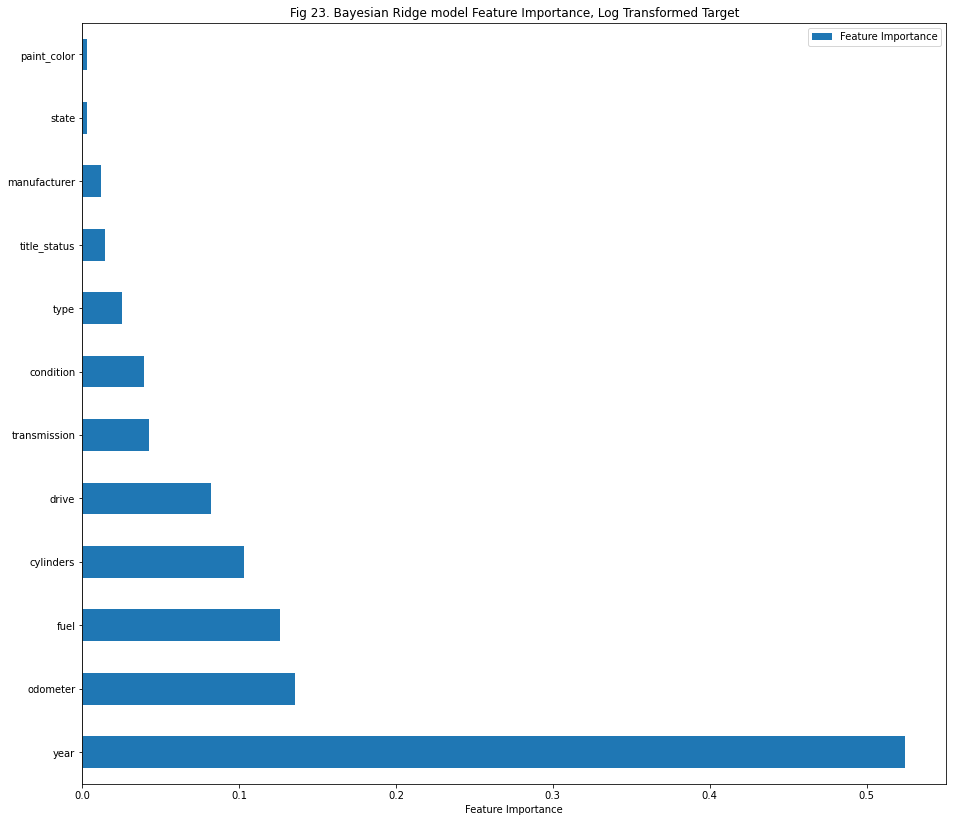

In [368]:
feature_importance_pipeline9_df.plot.barh(figsize=(20, 14))
plt.title("Fig 23. Bayesian Ridge model Feature Importance, Log Transformed Target")
plt.axvline(x=0, color=".5")
plt.xlabel("Feature Importance")
plt.subplots_adjust(left=0.3)
plt.savefig('fig 23.png')

#### Coefficient Importance

In [369]:
feature_names = pipeline9[:-1].get_feature_names_out()

coefs_pipeline9 = pd.DataFrame(
    pipeline9[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs_pipeline9

,Coefficients
1,2.469666e-02
scaler__odometer,8.530836e+01
remainder__region,-9.726331e-02
remainder__year,9.011524e+01
remainder__manufacturer,-1.999572e+00
...,...
remainder__type remainder__state^2,2.640153e-06
remainder__paint_color^3,2.314275e-05
remainder__paint_color^2 remainder__state,-1.053005e-05
remainder__paint_color remainder__state^2,-4.245065e-07


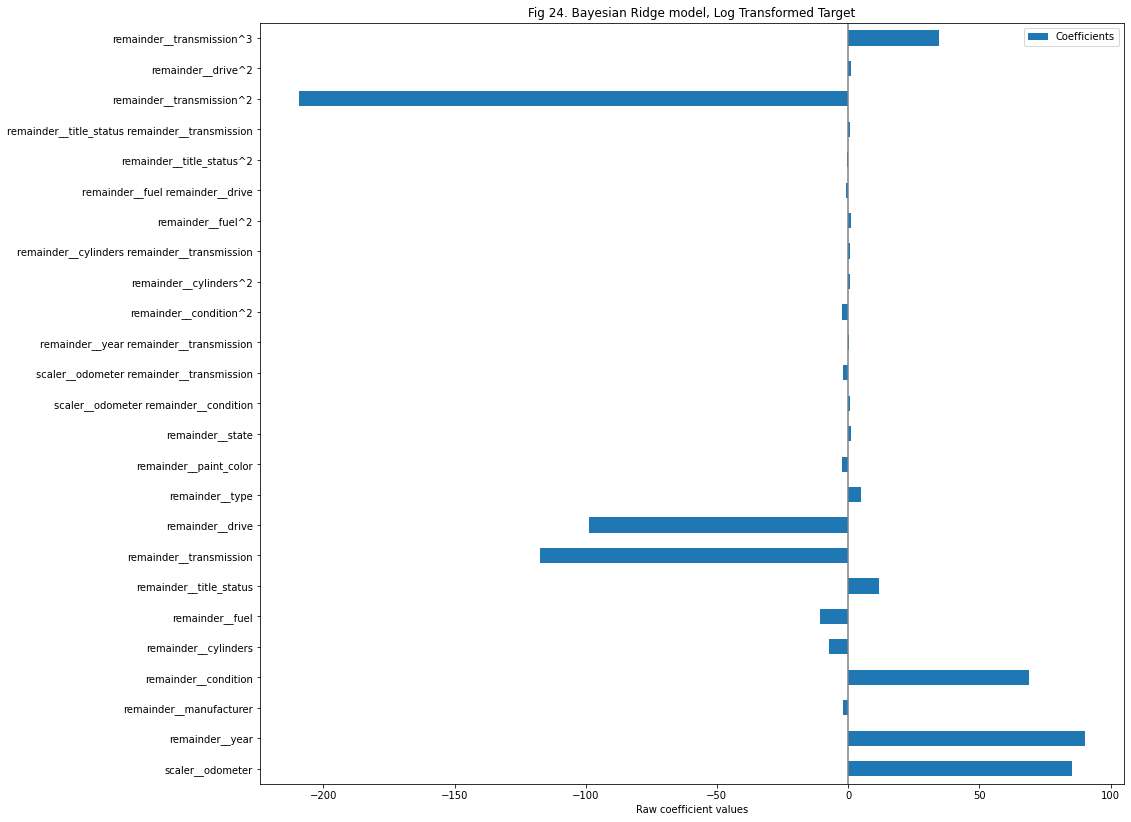

In [370]:
coefs_pipeline9[abs(coefs_pipeline9['Coefficients']) >0.5].plot.barh(figsize=(20, 14))
plt.title("Fig 24. Bayesian Ridge model, Log Transformed Target")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
plt.savefig('fig 24.png')

#### Evaluation ####

In the third iteration of CRISP-DM framework , for the data set with imputed/encoded null values and removed/addressed outliers, bayesian Rdge regression model with polynomial features was used to predict the outcome variable and find the most important feautures affecting the price. The MAE (4958.3), MAPE(0.35), and MSLE(0.18) were about 60%, 45%, 90% less than the baseline error values. The R^2 value of this model was computed to be 0.69 (~0.70) which indates that the model is a good fit for the data set we have to predict the out come variable.  

This model also addresses the negative predictions we got in previous models through logarithmis transformation of the target variable. 

Features : The important feautures predicted by this model are year, odometer, fuel, cylinders, drive, transmission, condition, type, title_status and manufacturer. Upon cross-examining this with perason correaltion plots of these datasets we can conclude that odometer, year, fuel, cylinders, transmission and type happen to be important feature to take into consideration while fine tuning an used car inventory. 

Coefficients of the model: Odometer, year, transmission and drive seem to have the highest coefficients. 
The  Bayesian probablistic model used with regularization of Ridge regression and priors of the gaussian is equivalent to finding a maximum a posterior estimation (Bayesian part of the model:under a Gaussian prior) over the coefficients (Ridge part of the model:given by a spherical Gaussian). 

By this method, hence, we are able to get distribution of each coefficient with which we can construct the credible interval, which provides us the probability that a specific coefficient falls into this credible interval. It is to be noted that a small coefficient of a parameter indicates that the marginal effect of the predictor is negligible. It is also to be noted here that the coefficients explain the relationship between the given attribute tot he taget variable while the feature importance describe the imporatnace of given attribute in predicting the target variable. For instance the coefficents relate whther the predictor is having a negative or positive impact and how the impact can be measured on the target variable.

We can also use the posterior distribution of the coefficients to analyze the probability of a particular observation being an outlier (we may defined such probabiilty to be the probability that the error term is  
k standard deviations away from 0). This probability is based on information of all data, instead of just the observation itself. 

This would be of particular help when using Bayesian regression for this dataset beacuse of the complexity of the data (as there are many outliers in the data we have seen like antique cars etc.) and might help in determination if the car with given features is an outlier. Such a finding might be of business importance through 1. help in decision-making of a particular dealer if the store wants to have an outlier vehicle in its inventory 2. flexibility for setting the boundaries(confidence interval) for outlier determination based on each dealership. 

### DATAFRAME 2 : DF_odo

#### 4.3. Creating Training and Development data for modeling and model improvement

In [371]:
# split the data into training data and develoment data using 

X = DF_odo.drop(columns = ['price'])
y = DF_odo['price']
        
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [372]:
X_train.head().append(X_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/4211938313.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train.head().append(X_train.tail())


,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
57598,38,2013.0,37,0,3,2,132688.0,0,0,0,8,10,26
88342,391,2014.0,13,0,3,3,164000.0,0,0,1,9,10,38
19143,112,2007.0,37,2,3,2,102000.0,0,0,0,0,9,5
4500,105,2004.0,14,2,6,2,199000.0,0,0,0,0,0,2
51118,128,2017.0,40,0,3,2,41000.0,0,1,1,9,0,22
54886,216,2007.0,16,2,5,2,187000.0,0,0,1,11,2,23
76820,61,2008.0,16,0,3,2,142819.0,0,0,1,9,5,35
103694,288,2010.0,16,3,3,2,105731.0,0,0,1,4,5,45
860,151,2020.0,7,2,6,2,12880.0,0,0,0,8,10,1
15795,350,2006.0,13,0,5,2,145312.0,0,1,0,8,5,4


In [373]:
X_train.shape

(73529, 13)

In [374]:
y_train.head().append(y_train.tail())

/var/folders/0f/18jt_y8s26xfq075263fxb6c0000gn/T/ipykernel_4232/3570967498.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train.head().append(y_train.tail())


57598      8400
88342      7995
19143      6900
4500       5200
51118     14995
54886      4899
76820      5199
103694     5990
860       41990
15795     13999
Name: price, dtype: int64

In [375]:
# create the baseline for error analysis
baseline_train = np.ones(shape = y_train.shape)*y_train.mean()
baseline_dev = np.ones(shape = y_dev.shape)*y_dev.mean()

mae_baseline_train = mean_absolute_error(baseline_train, y_train)
mae_baseline_dev = mean_absolute_error(baseline_dev, y_dev)

mape_baseline_train = mean_absolute_percentage_error(baseline_train, y_train)
mape_baseline_dev = mean_absolute_percentage_error(baseline_dev, y_dev)

msle_baseline_train = mean_squared_log_error(baseline_train, y_train)
msle_baseline_dev = mean_squared_log_error(baseline_dev, y_dev)

In [376]:
#printing the baseline error
print('The mean absolute baseline training error is: ', mae_baseline_train)
print('The mean absolute baseline development error is: ', mae_baseline_dev)

print('The mean absolute percentage baseline training error is: ', mape_baseline_train)
print('The mean absolute percentage baseline development error is: ', mape_baseline_dev)

print('The mean squared log baseline training error is: ', msle_baseline_train)
print('The mean squared log baseline development error is: ', msle_baseline_dev)

The mean absolute baseline training error is:  10380.099567036323
The mean absolute baseline development error is:  10316.746955829449
The mean absolute percentage baseline training error is:  0.6349775822531026
The mean absolute percentage baseline development error is:  0.6348811102533882
The mean squared log baseline training error is:  0.8097739427337933
The mean squared log baseline development error is:  0.8119458510253174


#### MODEL 10: Polynomial degree, BaysianRidge regression, Transformed Target, gradient decent optimization,Permutation importance for feature selection

In [377]:
# scaling columns as aplha is sensitive to magnitude of feature

preprocessor = ColumnTransformer(
        transformers=[('scaler', StandardScaler(), ['odometer'])],
        remainder='passthrough'
                                )

# Building pipe line for the selected model 

pipeline10 = Pipeline([('prep', preprocessor),
                      ('feature_transform', PolynomialFeatures(degree=3, include_bias=True)),
                      ('lossfunction',  TransformedTargetRegressor(regressor=BayesianRidge(fit_intercept=True),
                        func=np.log10,
                        inverse_func=sp.special.exp10))])
                    
pipeline10.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['odometer'])])),
                ('feature_transform', PolynomialFeatures(degree=3)),
                ('lossfunction',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=BayesianRidge()))])

In [378]:
pipeline10.score(X_dev,y_dev)

0.757934272135065

In [379]:
train_preds = pipeline10.predict(X_train)
dev_preds = pipeline10.predict(X_dev)
pipeline10_train_mae = mean_absolute_error(y_train, train_preds)
pipeline10_dev_mae = mean_absolute_error(y_dev, dev_preds)

print('The mean absolute training error is: ', pipeline10_train_mae)
print('The mean absolute testing error is: ', pipeline10_dev_mae)

The mean absolute training error is:  3837.036861892982
The mean absolute testing error is:  3886.186041926448


In [380]:
pipeline10_train_mape = mean_absolute_percentage_error(y_train, train_preds)
pipeline10_dev_mape = mean_absolute_percentage_error(y_dev, dev_preds)

print('MAPE Train is: ', pipeline10_train_mape)
print('MAPE Dev is: ', pipeline10_dev_mape)

MAPE Train is:  0.3133696684177717
MAPE Dev is:  0.32215591798169163


In [381]:
pipeline10_train_msle = mean_squared_log_error(train_preds, y_train)
pipeline10_dev_msle = mean_squared_log_error(dev_preds, y_dev)

print('MSLE Train is: ', pipeline10_train_msle)
print('MSLE Dev is: ', pipeline10_dev_msle)

MSLE Train is:  0.1494121601018296
MSLE Dev is:  0.15662374143361452


In [382]:
min(train_preds)

490.67330543693765

In [383]:
min(dev_preds)

302.669410571754

In [384]:
feature_importance_pipeline10 = {}
r = permutation_importance(pipeline10, X_dev, y_dev, n_repeats=30, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] >0:
        print(f"{X_dev.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")
        feature_importance_pipeline10[X_dev.columns[i]]=r.importances_mean[i]

odometer0.173 +/- 0.014
drive   0.129 +/- 0.003
fuel    0.079 +/- 0.002
condition0.032 +/- 0.004
type    0.031 +/- 0.002
manufacturer0.027 +/- 0.002
state   0.004 +/- 0.001
paint_color0.003 +/- 0.001


In [385]:
feature_importance_pipeline10_df = pd.DataFrame(feature_importance_pipeline10,index=[0]).T
feature_importance_pipeline10_df = feature_importance_pipeline10_df.rename(columns={0: "Feature Importance"})
feature_importance_pipeline10_df

,Feature Importance
odometer,0.173119
drive,0.128842
fuel,0.079377
condition,0.031864
type,0.030935
manufacturer,0.027146
state,0.003506
paint_color,0.002614


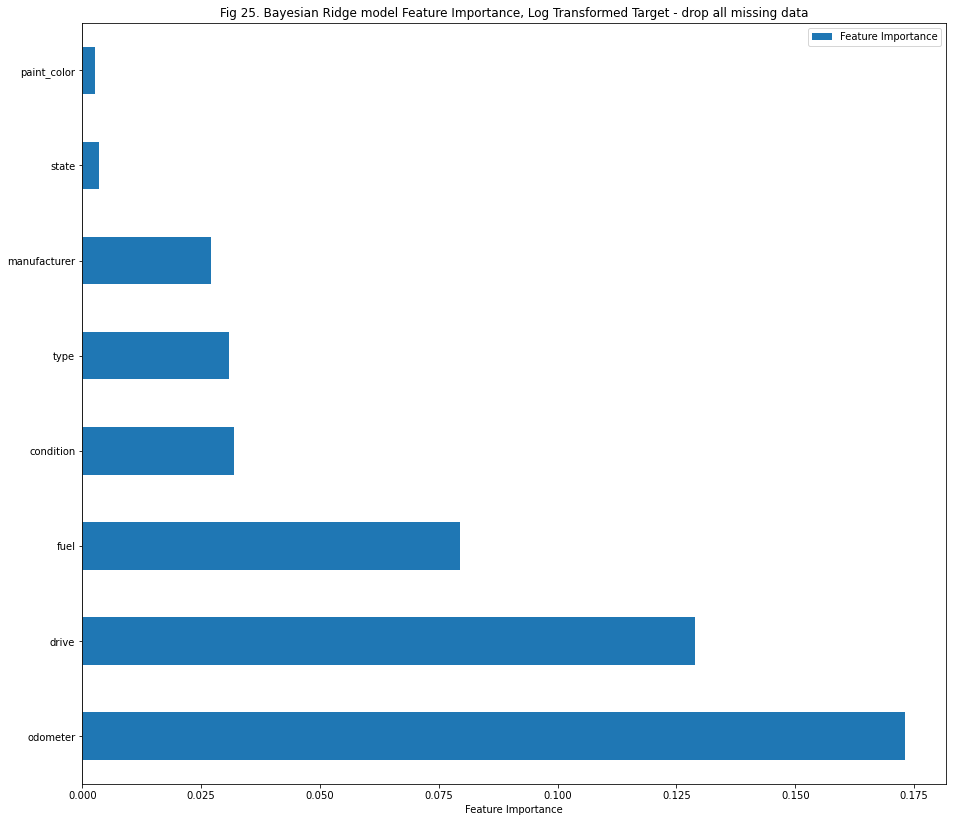

In [386]:
feature_importance_pipeline10_df.plot.barh(figsize=(20, 14))
plt.title("Fig 25. Bayesian Ridge model Feature Importance, Log Transformed Target - drop all missing data")
plt.axvline(x=0, color=".5")
plt.xlabel("Feature Importance")
plt.subplots_adjust(left=0.3)
plt.savefig('fig 25.png')

#### Coefficient Importance

In [387]:
feature_names = pipeline10[:-1].get_feature_names_out()

coefs_pipeline10 = pd.DataFrame(
    pipeline10[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs_pipeline10

,Coefficients
1,3.153260e-04
scaler__odometer,1.677292e+01
remainder__region,-4.019846e-02
remainder__year,7.705366e+01
remainder__manufacturer,9.007562e+00
...,...
remainder__type remainder__state^2,1.071720e-06
remainder__paint_color^3,-1.903725e-05
remainder__paint_color^2 remainder__state,-2.569471e-06
remainder__paint_color remainder__state^2,-1.067816e-07


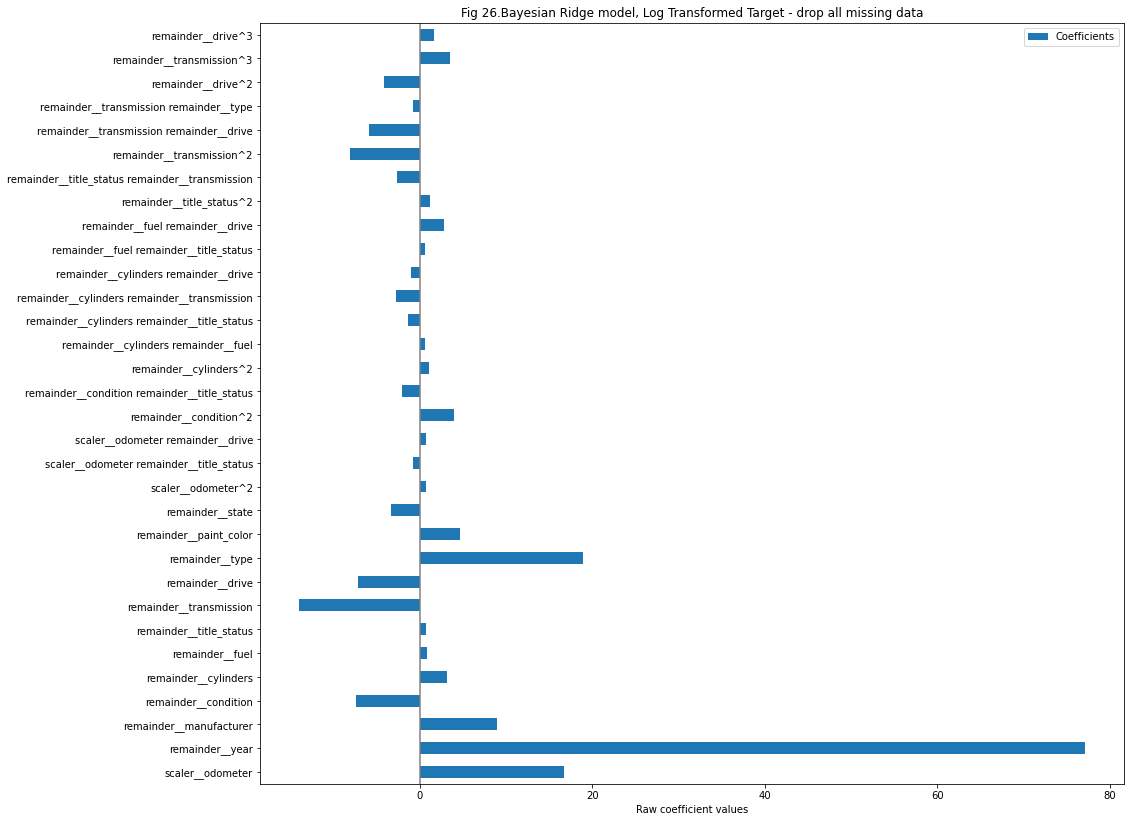

In [388]:
coefs_pipeline10[abs(coefs_pipeline10['Coefficients']) >0.5].plot.barh(figsize=(20, 14))
plt.title("Fig 26.Bayesian Ridge model, Log Transformed Target - drop all missing data")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
plt.savefig('fig 26.png')

#### Evaluation ####

In the third iteration of CRISP-DM framework , for the data set with dropped null values and removed/addressed outliers, bayesian Rdge regression model with polynomial features was used to predict the outcome variable and find the most important feautures affecting the price. This model has been better compared to all other models we tested.

The MAE (3886.3), MAPE(0.32), and MSLE( 0.15) were about 70%, 50%, 90% less than the baseline error values. The R^2 value of this model was computed to be 0.76 (~0.70) which indates that the model is a good fit for the data set we have to predict the out come variable.  

This model also addresses the negative predictions we got in previous models through logarithmis transformation of the target variable. 

Features: The important features predicted by this model are odometer, fuel, drive, condition, typeand  manufacturer. Upon cross-examining this with perason correaltion plots of these datasets we can conclude that odometer, year, fuel, cylinders, transmission, type and manufacturer happen to be important features (in the order given) to take into consideration while fine tuning an used car inventory. 

Coefficients Interpretation:The feautures odometer, year and type have larger coeeficients than many other vaiables for the dataset with all null values dropped for categorical columns.  The  Bayesian probablistic model used with regularization of Ridge regression and priors of the gaussian is equivalent to finding a maximum a posterior estimation (Bayesian part of the model:under a Gaussian prior) over the coefficients (Ridge part of the model:given by a spherical Gaussian). 

By this method, hence, we are able to get distribution of each coefficient with which we can construct the credible interval, which provides us the probability that a specific coefficient falls into this credible interval. Recall that a small coefficient of a parameter indicates that the marginal effect of the predictor is negligible.

We can also use the posterior distribution of the coefficients to analyze the probability of a particular observation being an outlier (we may defined such probabiilty to be the probability that the error term is  
k standard deviations away from 0). This probability is based on information of all data, instead of just the observation itself. 

This would be of particular help when using Bayesian regression for this dataset beacuse of the complexity of the data (as there are many outliers in the data we have seen like antique cars etc.) and might help in determination if the car with given features is an outlier. Such a finding might be of business importance through 1. help in decision-making of a particular dealer if the store wants to have an outlier vehicle in its inventory 2. flexibility for setting the boundaries(confidence interval) for outlier determination based on each dealership. 

It is also to be noted here that the coefficients explain the relationship between the given attribute tot he taget variable while the feature importance describe the imporatnace of given attribute in predicting the target variable. For instance the coefficents relate whther the predictor is having a negative or positive impact and how the impact can be measured on the target variable. 

### Footnote:

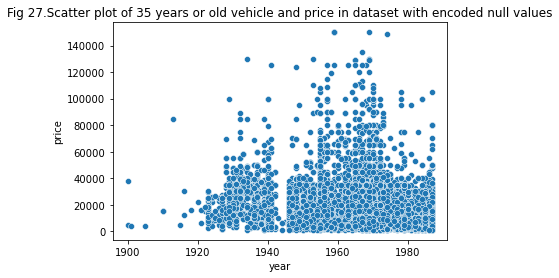

In [389]:
# Visualization of Vehicles that are more than 35 years old and their price 

sns.scatterplot(data=DF_nan_odo[DF_nan_odo['year']<1988], x='year',y='price').set(title='Fig 27.Scatter plot of 35 years or old vehicle and price in dataset with encoded null values')
plt.savefig('fig 27.png')
            
            

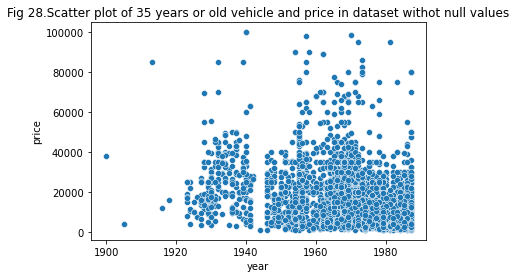

In [390]:
sns.scatterplot(data=DF_odo[DF_odo['year']<1988], x='year',y='price').set(title='Fig 28.Scatter plot of 35 years or old vehicle and price in dataset withot null values')
plt.savefig('fig 28.png')
            

Further tuning of the model could be acheived through classification of the datasets where old cars that are 20 years and older are classified OR we can create categorical column if the vehicle is considered as antique(before 1975,>45 years old), vintage(1919-1930) or classic cars(before 2000, >20years old). This could improve the accuracy of the the current model as well. 